In [1]:
import json
import pandas as pd
import numpy as np
import sys
import re

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import Counter

from parse_data import *
p_group_dict = make_p_group_dict()

import xlrd
import pickle
%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)

pd.set_option('display.float_format', lambda x: '%.5f' % x)


palette_list = list(sns.color_palette("colorblind"))


In [2]:
#Define resolution: DO NOT CHANGE - P group is assumed as the resolution
resolution = 'P group'


# Load data:
with open('result_data/full_typing_results_full_dataset.json', 'r') as infile:
    full_typing_dict = json.load(infile)

#Load gold standard data
gold_standard_df = pd.read_pickle('result_data/gs_two_field_df.pkl')

#Load overview of population ethnicity
pop_df = pd.read_csv('/work/nthu/publications/github_file_structure/reference_data/2018_1129_HLA_types_full_1000_Genomes_Project_panel.txt', sep='\t', comment='#')
pop_conversion_dict = {row['Sample ID'] : row['Population'] for i, row in pop_df.iterrows()} 

#Load overview of how the populations are grouped into supergroups
superpop_df = pd.read_csv('../reference_data/1000G_superpopulations.tsv', sep='\t', comment='#')
superpop_conversion_dict = {row['Population Code'].strip() : row['Super Population Code'].strip() for i, row in superpop_df.iterrows()} 

In [3]:
#Function for validating an allele call at a locus:

def validate_call(correct_alleles, predicted_alleles):

    #Start by converting the alleles to the correct resolution
    correct_call_1 = {convert_to_p_group(allele, p_group_dict=p_group_dict) for allele in correct_alleles[0]}
    correct_call_2 = {convert_to_p_group(allele, p_group_dict=p_group_dict) for allele in correct_alleles[1]}

    pred_1 = {convert_to_p_group(predicted_alleles[0][0], p_group_dict=p_group_dict)}
    pred_2 = {convert_to_p_group(predicted_alleles[1][0], p_group_dict=p_group_dict)}

    try:
        correct_0_pred_0 = list(correct_call_1.intersection(pred_1))
        correct_1_pred_1  = list(correct_call_2.intersection(pred_2))

        option_1 = [correct_0_pred_0, correct_1_pred_1]

        correct_0_pred_1  = list(correct_call_1.intersection(pred_2))
        correct_1_pred_0  = list(correct_call_2.intersection(pred_1))

        option_2 = [correct_0_pred_1, correct_1_pred_0]

        hits_1 = len([i for i in option_1 if i != []])
        hits_2 = len([i for i in option_2 if i != []])

        num_correct_hits = max(hits_1,hits_2)
        
        
    except KeyError as error:
        num_correct_hits = 0
    
    correct_call = [list(correct_call_1), list(correct_call_2)]
    pred_call = [list(pred_1), list(pred_2)]

    return num_correct_hits, correct_call, pred_call

# Analyse population distribution in the 1000G dataset:


In [4]:
pop_count_list = [pop_conversion_dict[sample_id] for sample_id in gold_standard_df.index]
len(Counter(pop_count_list))

15

In [5]:
pop_count_list = [superpop_conversion_dict[pop_conversion_dict[sample_id]] for sample_id in gold_standard_df.index]
Counter(pop_count_list)

Counter({'EUR': 340, 'AFR': 187, 'AMR': 201, 'EAS': 101})

# Create a reference for allele frequencies in the world

In [6]:
#Load US donor population freqs
us_donor_freqs = dict()
for locus in ['A', 'B', 'C', 'DRB1', 'DQB1']:
    us_donor_freqs[locus] = pd.read_excel(f'/work/nthu/publications/github_file_structure/reference_data/US_population_freqs/{locus}.xls')
    us_donor_freqs[locus] = us_donor_freqs[locus].rename(columns = {locus : 'allele'})

us_doner_freqs_df = pd.concat(us_donor_freqs.values(), ignore_index=True)
us_doner_freqs_df.head()

,allele,AAFA_freq,AAFA_rank,AFA_freq,AFA_rank,AFB_freq,AFB_rank,AINDI_freq,AINDI_rank,AISC_freq,AISC_rank,ALANAM_freq,ALANAM_rank,AMIND_freq,AMIND_rank,API_freq,API_rank,CARB_freq,CARB_rank,CARHIS_freq,CARHIS_rank,CARIBI_freq,CARIBI_rank,CAU_freq,CAU_rank,EURCAU_freq,EURCAU_rank,FILII_freq,FILII_rank,HAWI_freq,HAWI_rank,HIS_freq,HIS_rank,JAPI_freq,JAPI_rank,KORI_freq,KORI_rank,MENAFC_freq,MENAFC_rank,MSWHIS_freq,MSWHIS_rank,NAM_freq,NAM_rank,NCHI_freq,NCHI_rank,SCAHIS_freq,SCAHIS_rank,SCAMB_freq,SCAMB_rank,SCSEAI_freq,SCSEAI_rank,VIET_freq,VIET_rank
0,A*68:06,0.00000,NaN,0.00000,197.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00001,71.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,194.00000,0.00000,179.00000,0.00000,NaN,0.00000,NaN,0.00009,54.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00017,47.00000,0.00001,83.00000,0.00000,NaN,0.00003,75.00000,0.00010,61.00000,0.00000,NaN,0.00000,NaN
1,A*11:46,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,272.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN
2,A*03:48,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,237.00000,0.00000,231.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN
3,A*02:215,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,241.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,398.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN
4,A*23:05,0.00002,62.00000,0.00003,62.00000,0.00005,62.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00006,62.00000,0.00008,49.00000,0.00014,49.00000,0.00000,204.00000,0.00000,180.00000,0.00000,NaN,0.00000,NaN,0.00005,58.00000,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00003,60.00000,0.00000,NaN,0.00000,NaN,0.00006,62.00000,0.00010,57.00000,0.00000,NaN,0.00000,NaN


In [7]:
#Calculate overall allele frequency across broad race groups (taken from US donor registry)
pop_counts_df = pd.read_csv('../reference_data/US_population_freqs/pupulation_counts.tsv', sep='\t', comment='#')  

broad_race_groups = list()
for race_group in pop_counts_df['Broad race group'].unique():
    race_dict = dict()
    race_dict['Race code'] = race_group
    race_dict['Count'] = sum(pop_counts_df[pop_counts_df['Broad race group'] == race_group]['Count'])
    race_dict['Typed C'] = sum(pop_counts_df[pop_counts_df['Broad race group'] == race_group]['Typed C'])
    race_dict['Typed DQB1'] = sum(pop_counts_df[pop_counts_df['Broad race group'] == race_group]['Typed DQB1'])
    broad_race_groups += [race_dict]

broad_group_counts_df = pd.DataFrame(broad_race_groups)
broad_group_counts_df

,Race code,Count,Typed C,Typed DQB1
0,AFA,483355,117860,19725
1,API,520860,95936,19898
2,NAM,57432,14180,3663
3,HIS,523323,103607,22905
4,CAU,1313780,418013,85521


In [8]:
#Calculate the overall allele (in P group resolution) frequency across all race groups and for the invidicual super population groups

world_count_dict = {pop_group : dict() for pop_group in ['world_freq'] + [f'{group}_freq' for group in broad_group_counts_df['Race code']]}
world_freq_dict = {pop_group : dict() for pop_group in ['world_freq'] + [f'{group}_freq' for group in broad_group_counts_df['Race code']]}


for i, row in us_doner_freqs_df.iterrows():
    allele = row['allele']
    for pop_group in world_freq_dict:

        
        #Find the number of individuals for this locus for each race group 
        if allele.startswith('C'):
            world_counts = dict([row for i, row in broad_group_counts_df[['Race code', 'Typed C']].iterrows()])
        elif allele.startswith('DQB1'):
            world_counts = dict([row for i, row in broad_group_counts_df[['Race code', 'Typed DQB1']].iterrows()])
        else:
            world_counts = dict([row for i, row in broad_group_counts_df[['Race code', 'Count']].iterrows()])

        allele_counts = 0
        #Calculate the total world "allele count" for the allele
        # by multiplying frequency in race groups with the nubmer of individuals in the group
        if pop_group == 'world_freq':
            for pop_group_2 in broad_group_counts_df['Race code']:
                allele_counts += float(us_doner_freqs_df[us_doner_freqs_df['allele'] == allele][f'{pop_group_2}_freq'] * world_counts[pop_group_2])
        else:
            allele_counts += float(us_doner_freqs_df[us_doner_freqs_df['allele'] == allele][f'{pop_group}'] * world_counts[pop_group.replace('_freq', '')])

        #Add counts to dict with counts for all alleles in P group resolution
        allele_p_group = convert_to_p_group(allele.replace('g', ''), p_group_dict=p_group_dict)

        if allele_p_group in world_count_dict[pop_group]:
            world_count_dict[pop_group][allele_p_group] += allele_counts
        else:
            world_count_dict[pop_group][allele_p_group] = allele_counts

        #print(pop_group)

#Estimate the world frequency by dividing by the total number of individuals tested for this locus in the full dataset
for pop_group, pop_count_dict in world_count_dict.items():
    if pop_group == 'world_freq':
        for allele, count in pop_count_dict.items():
            if allele.startswith('C'):
                total_count = sum(broad_group_counts_df['Typed C'])
            elif allele.startswith('DQB1'):
                total_count = sum(broad_group_counts_df['Typed DQB1'])
            else:
                total_count = sum(broad_group_counts_df['Count'])

            allele_freq = count / total_count

            world_freq_dict[pop_group][allele] = allele_freq
    else:
        for allele, count in pop_count_dict.items():
            pop_count_row = broad_group_counts_df[broad_group_counts_df['Race code'] == pop_group.replace('_freq', '')]

            if allele.startswith('C'):
                total_count = pop_count_row['Typed C'].values[0]
            elif allele.startswith('DQB1'):
                total_count = pop_count_row['Typed DQB1'].values[0]
            else:
                total_count = pop_count_row['Count'].values[0]

            allele_freq = count / total_count

            world_freq_dict[pop_group][allele] = allele_freq

mhc_freq_df = pd.DataFrame(world_freq_dict).reset_index().rename(columns={'index' : 'allele'})
mhc_freq_df.sort_values('world_freq', ascending=False).head()

,allele,world_freq,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq
639,A*02:01,0.20172,0.12223,0.08435,0.26508,0.20955,0.27160
2871,DQB1*03:01,0.19505,0.18509,0.18486,0.23702,0.20147,0.19620
2868,DQB1*02:01,0.19496,0.21446,0.13067,0.16980,0.17499,0.21185
2089,C*04:01,0.13462,0.20596,0.09612,0.13232,0.16803,0.11515
2124,C*07:01,0.12846,0.11682,0.05546,0.11619,0.10370,0.15505


In [9]:
# ##Compare to previous estimation of world population HLA frequencies
# garde_mhc_freq = pd.read_csv('/work/nthu/publications/github_file_structure/reference_data/mhc_freq.csv', sep='\t')
# garde_mhc_freq = garde_mhc_freq[garde_mhc_freq['population'] == 'World']
# garde_mhc_freq['allele'] = garde_mhc_freq['allele'].str.replace('HLA-', '')
# garde_mhc_freq = garde_mhc_freq[garde_mhc_freq['locus'].isin(['HLA-A', 'HLA-B', 'HLA-C', 'HLA-DRB1', 'HLA-DQB1'])]
# garde_mhc_freq = garde_mhc_freq.rename(columns={'freq' : 'garde_freq'})
# merged_df = pd.merge(garde_mhc_freq, mhc_freq_df, on='allele')
# merged_df['diff'] = abs(merged_df['freq'] - merged_df['garde_freq'])
# merged_df.sort_values('diff', ascending=False).head(10)

# merged_df.plot.scatter(x='freq', y = 'garde_freq')

In [10]:
#Analyse statistics over mhc world frequencies
print(len(mhc_freq_df))
print(len(mhc_freq_df[mhc_freq_df['world_freq'] > 1/2000]))
print(sum(mhc_freq_df[mhc_freq_df['world_freq'] > 1/2000]['world_freq']))
print(sum(mhc_freq_df[mhc_freq_df['world_freq'] < 1/2000]['world_freq']))

2912
224
4.9727107888117015
0.027287752836121795


# Analyse allele frequencies and typing accuracy per allele in the gold standard dataset

Are there any systematic errors by individual tools?

In [11]:
# # Allele frequencies
# all_alleles_dict = list()
# # for gene in ['A', 'B', 'C', 'DRB1', 'DQB1']:
# #     all_alleles_dict[gene] = list()

# p_group_dict = make_p_group_dict()

# for sample, row in gold_standard_df.iterrows():
#     for gene, val in row.items():
#         all_alleles_dict += [i[0] for i in val]

# df = pd.DataFrame(all_alleles_dict, index=['Counts']).T.sort_values('Counts')
# df.plot.bar()

In [12]:
#Split gold standard typing into two and choose the most frequent one
gold_standard_df.index.name = None

gs_split_dict = dict()
for sample, row in gold_standard_df.iterrows():
    gs_split_dict[sample] = dict()
    for locus in gold_standard_df.columns:
        gs_split_dict[sample][f'{locus}.1'] = row[locus][0]
        gs_split_dict[sample][f'{locus}.2'] = row[locus][1]

gs_split_df = pd.DataFrame(gs_split_dict).T
gs_split_df.head()

,A.1,A.2,B.1,B.2,C.1,C.2,DRB1.1,DRB1.2,DQB1.1,DQB1.2
NA06985,[A*03:01],[A*02:01],[B*07:02],[B*57:01],[C*07:02],[C*06:02],[DRB1*15:01],[DRB1*15:01],[DQB1*06:02],[DQB1*06:02]
NA06986,[A*03:01],[A*32:01],[B*44:03],[B*44:03],[C*04:01],[C*16:01],[DRB1*07:01],[DRB1*07:01],[DQB1*02:02],[DQB1*02:02]
NA06994,[A*02:01],[A*32:01],[B*40:02],[B*08:01],[C*02:02],"[C*07:06, C*07:01]",[DRB1*01:01],[DRB1*04:04],[DQB1*05:01],[DQB1*03:02]
NA07000,[A*02:01],[A*68:01],[B*44:02],[B*40:01],"[C*03:04, C*03:03]",[C*07:04],[DRB1*03:01],[DRB1*11:01],[DQB1*02:01],[DQB1*03:01]
NA07037,[A*30:01],[A*31:01],[B*15:10],[B*40:01],[C*03:04],[C*03:04],[DRB1*04:04],[DRB1*13:02],[DQB1*03:02],[DQB1*06:04]


In [13]:
resolution

'P group'

In [14]:


pred_dict = dict()

for sample in gold_standard_df.index:
    pred_dict[sample] = dict()
    for locus in gold_standard_df.columns:
        for tool in full_typing_dict[resolution]:
            if 'prediction' in full_typing_dict[resolution][tool][locus][sample]:
                pred_dict[sample][f'{locus}-{tool}'] = full_typing_dict[resolution][tool][locus][sample]['prediction']
                pred_dict[sample][f'{locus}-{tool}_miscalls'] = full_typing_dict[resolution][tool][locus][sample]['miscalls']
            else:
                pred_dict[sample][f'{locus}-{tool}'] = ''
                pred_dict[sample][f'{locus}-{tool}_miscalls'] = 0

miscalls_df = pd.DataFrame(pred_dict).T

miscalls_overview_df = gold_standard_df.join(miscalls_df)

for locus in gold_standard_df.columns:
    miscalls_overview_df[f'{locus}-consensus_miscall'] = miscalls_overview_df[f'{locus}-Kourami_miscalls'] + miscalls_overview_df[f'{locus}-HLA-LA_miscalls'] + miscalls_overview_df[f'{locus}-Hisatgenotype_miscalls'] + miscalls_overview_df[f'{locus}-Optitype_miscalls']
miscalls_overview_df.sort_values('A-consensus_miscall', ascending=False).head(2)



,A,B,C,DRB1,DQB1,A-Kourami,A-Kourami_miscalls,A-HLA-LA,A-HLA-LA_miscalls,A-Optitype,A-Optitype_miscalls,A-Hisatgenotype,A-Hisatgenotype_miscalls,A-STC-seq,A-STC-seq_miscalls,B-Kourami,B-Kourami_miscalls,B-HLA-LA,B-HLA-LA_miscalls,B-Optitype,B-Optitype_miscalls,B-Hisatgenotype,B-Hisatgenotype_miscalls,B-STC-seq,B-STC-seq_miscalls,C-Kourami,C-Kourami_miscalls,C-HLA-LA,C-HLA-LA_miscalls,C-Optitype,C-Optitype_miscalls,C-Hisatgenotype,C-Hisatgenotype_miscalls,C-STC-seq,C-STC-seq_miscalls,DRB1-Kourami,DRB1-Kourami_miscalls,DRB1-HLA-LA,DRB1-HLA-LA_miscalls,DRB1-Optitype,DRB1-Optitype_miscalls,DRB1-Hisatgenotype,DRB1-Hisatgenotype_miscalls,DRB1-STC-seq,DRB1-STC-seq_miscalls,DQB1-Kourami,DQB1-Kourami_miscalls,DQB1-HLA-LA,DQB1-HLA-LA_miscalls,DQB1-Optitype,DQB1-Optitype_miscalls,DQB1-Hisatgenotype,DQB1-Hisatgenotype_miscalls,DQB1-STC-seq,DQB1-STC-seq_miscalls,A-consensus_miscall,B-consensus_miscall,C-consensus_miscall,DRB1-consensus_miscall,DQB1-consensus_miscall
NA12275,"[[A*23:01], [A*03:01]]","[[B*14:01], [B*07:02]]","[[C*08:02], [C*07:02]]","[[DRB1*12:01], [DRB1*15:01]]","[[DQB1*03:01], [DQB1*06:02]]","[[A*02:110], [A*29:18]]",2,"[[A*23:04], [A*03:123]]",2,"[[A*02:01], [A*03:01]]",1,"[[A*02:95], [A*23:01]]",1,"[[A*03:01], [A*29:03]]",1,"[[B*07:202], [B*44:46]]",2,"[[B*44:46], [B*81:01]]",2,"[[B*14:01], [B*40:01]]",1,"[[B*07:02], [B*14:01]]",0,"[[B*07:02], [B*14:01]]",0,"[[C*03:86], [C*07:51]]",2,"[[C*16:07], [C*03:04]]",2,"[[C*03:04], [C*07:02]]",1,"[[C*08:94], [C*16:01]]",2,"[[C*03:04], [C*08:94]]",2,"[[DRB1*13:02], [DRB1*15:01]]",1,"[[DRB1*13:02], [DRB1*15:01]]",1,,2,"[[DRB1*13:02], [DRB1*12:03]]",2,"[[DRB1*07:01], [DRB1*15:01]]",1,"[[DQB1*06:04], [DQB1*06:02]]",1,"[[DQB1*03:01], [DQB1*06:04]]",1,,2,"[[DQB1*06:04], [DQB1*06:02]]",1,"[[DQB1*06:02], [DQB1*06:04]]",1,6,5,7,6,5
HG00500,"[[A*11:01, A*11:21], [A*11:01, A*11:21]]","[[B*40:55, B*40:01], [B*46:01, B*46:15]]","[[C*01:25, C*01:02], [C*07:74, C*07:66, C*07:50, C*07:02]]","[[DRB1*11:01], [DRB1*09:01]]","[[DQB1*03:03], [DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21]]",,2,"[[A*11:50], [A*11:01]]",1,"[[A*11:01], [A*11:01]]",0,"[[A*11:56], [A*11:74]]",2,,2,,2,"[[B*40:01], [B*46:01]]",0,"[[B*46:01], [B*40:01]]",0,"[[B*40:01], [B*46:01]]",0,,2,"[[C*07:02], [C*03:99]]",1,"[[C*01:02], [C*07:02]]",0,"[[C*07:02], [C*01:02]]",0,"[[C*01:02], [C*01:117]]",1,"[[C*01:05], [C*01:05]]",2,"[[DRB1*09:01], [DRB1*11:01]]",0,"[[DRB1*09:01], [DRB1*11:01]]",0,,2,"[[DRB1*09:01], [DRB1*11:01]]",0,"[[DRB1*09:01], [DRB1*11:136]]",1,,2,"[[DQB1*03:12], [DQB1*03:01]]",1,,2,"[[DQB1*03:03], [DQB1*03:10]]",1,,2,5,2,2,2,6


In [15]:
columns = [col for col in miscalls_overview_df.columns if not 'miscall' in col]
p_group_typing_overview_df = miscalls_overview_df[columns]
p_group_typing_overview_df.to_csv('paper_tables/TableS2.csv')
p_group_typing_overview_df.head()

,A,B,C,DRB1,DQB1,A-Kourami,A-HLA-LA,A-Optitype,A-Hisatgenotype,A-STC-seq,B-Kourami,B-HLA-LA,B-Optitype,B-Hisatgenotype,B-STC-seq,C-Kourami,C-HLA-LA,C-Optitype,C-Hisatgenotype,C-STC-seq,DRB1-Kourami,DRB1-HLA-LA,DRB1-Optitype,DRB1-Hisatgenotype,DRB1-STC-seq,DQB1-Kourami,DQB1-HLA-LA,DQB1-Optitype,DQB1-Hisatgenotype,DQB1-STC-seq
NA06985,"[[A*03:01], [A*02:01]]","[[B*07:02], [B*57:01]]","[[C*07:02], [C*06:02]]","[[DRB1*15:01], [DRB1*15:01]]","[[DQB1*06:02], [DQB1*06:02]]","[[A*03:01], [A*02:01]]","[[A*02:01], [A*03:01]]","[[A*03:01], [A*02:01]]","[[A*02:01], [A*03:01]]","[[A*02:01], [A*03:01]]","[[B*07:02], [B*07:235]]","[[B*07:02], [B*57:01]]","[[B*57:01], [B*07:02]]","[[B*07:02], [B*57:01]]","[[B*07:02], [B*07:02]]","[[C*07:02], [C*06:02]]","[[C*06:02], [C*07:02]]","[[C*06:02], [C*07:02]]","[[C*06:02], [C*07:02]]","[[C*06:116], [C*07:02]]","[[DRB1*15:01], [DRB1*15:01]]","[[DRB1*15:01], [DRB1*15:01]]",,"[[DRB1*15:01], [DRB1*15:01]]","[[DRB1*15:01], [DRB1*15:01]]","[[DQB1*06:02], [DQB1*06:02]]","[[DQB1*06:02], [DQB1*06:02]]",,"[[DQB1*06:02], [DQB1*06:02]]","[[DQB1*06:02], [DQB1*06:02]]"
NA06986,"[[A*03:01], [A*32:01]]","[[B*44:03], [B*44:03]]","[[C*04:01], [C*16:01]]","[[DRB1*07:01], [DRB1*07:01]]","[[DQB1*02:02], [DQB1*02:02]]","[[A*03:01], [A*32:01]]","[[A*03:01], [A*32:01]]","[[A*03:01], [A*32:01]]","[[A*03:01], [A*32:01]]","[[A*03:01], [A*74:13]]","[[B*44:03], [B*44:03]]","[[B*44:03], [B*44:03]]","[[B*44:03], [B*44:03]]","[[B*44:03], [B*44:03]]","[[B*44:03], [B*44:03]]","[[C*16:01], [C*04:01]]","[[C*04:01], [C*16:01]]","[[C*16:01], [C*04:01]]","[[C*04:01], [C*16:01]]","[[C*16:85], [C*16:85]]","[[DRB1*07:01], [DRB1*07:01]]","[[DRB1*07:01], [DRB1*07:01]]",,"[[DRB1*07:01], [DRB1*07:01]]",,"[[DQB1*02:01], [DQB1*02:18]]","[[DQB1*02:01], [DQB1*02:01]]",,"[[DQB1*02:01], [DQB1*02:01]]","[[DQB1*02:01], [DQB1*02:18]]"
NA06994,"[[A*02:01], [A*32:01]]","[[B*40:02], [B*08:01]]","[[C*02:02], [C*07:06, C*07:01]]","[[DRB1*01:01], [DRB1*04:04]]","[[DQB1*05:01], [DQB1*03:02]]","[[A*32:01], [A*02:01]]","[[A*02:01], [A*32:01]]","[[A*32:01], [A*02:01]]","[[A*32:01], [A*02:01]]","[[A*02:01], [A*32:01]]","[[B*08:01], [B*40:02]]","[[B*08:01], [B*40:02]]","[[B*40:02], [B*08:01]]","[[B*08:01], [B*40:02]]","[[B*08:01], [B*40:02]]","[[C*02:02], [C*07:01]]","[[C*07:01], [C*02:02]]","[[C*02:02], [C*07:01]]","[[C*02:02], [C*07:01]]",,"[[DRB1*01:01], [DRB1*04:04]]","[[DRB1*01:01], [DRB1*04:04]]",,"[[DRB1*01:01], [DRB1*04:04]]","[[DRB1*01:01], [DRB1*04:08]]","[[DQB1*05:01], [DQB1*03:02]]","[[DQB1*03:02], [DQB1*05:01]]",,"[[DQB1*03:02], [DQB1*05:01]]","[[DQB1*03:02], [DQB1*05:01]]"
NA07000,"[[A*02:01], [A*68:01]]","[[B*44:02], [B*40:01]]","[[C*03:04, C*03:03], [C*07:04]]","[[DRB1*03:01], [DRB1*11:01]]","[[DQB1*02:01], [DQB1*03:01]]","[[A*68:71], [A*02:01]]","[[A*02:01], [A*68:01]]","[[A*68:01], [A*02:01]]","[[A*68:71], [A*02:01]]","[[A*02:22], [A*68:08]]","[[B*44:02], [B*40:01]]","[[B*40:01], [B*44:02]]","[[B*40:01], [B*44:02]]","[[B*40:01], [B*44:02]]","[[B*40:01], [B*44:02]]",,"[[C*03:04], [C*07:04]]","[[C*07:04], [C*03:04]]","[[C*07:04], [C*03:04]]","[[C*03:04], [C*07:04]]","[[DRB1*11:01], [DRB1*03:01]]","[[DRB1*11:01], [DRB1*03:01]]",,"[[DRB1*11:01], [DRB1*03:01]]","[[DRB1*03:01], [DRB1*11:01]]","[[DQB1*02:01], [DQB1*03:01]]","[[DQB1*03:01], [DQB1*02:01]]",,"[[DQB1*02:01], [DQB1*03:01]]","[[DQB1*02:01], [DQB1*03:01]]"
NA07037,"[[A*30:01], [A*31:01]]","[[B*15:10], [B*40:01]]","[[C*03:04], [C*03:04]]","[[DRB1*04:04], [DRB1*13:02]]","[[DQB1*03:02], [DQB1*06:04]]","[[A*30:01], [A*31:01]]","[[A*30:01], [A*31:01]]","[[A*30:01], [A*31:01]]","[[A*30:01], [A*34:01]]","[[A*30:01], [A*31:115]]","[[B*15:10], [B*40:01]]","[[B*15:10], [B*40:01]]","[[B*15:10], [B*40:01]]","[[B*15:10], [B*40:01]]","[[B*15:10], [B*40:01]]","[[C*03:04], [C*03:04]]","[[C*03:04], [C*03:04]]","[[C*03:04], [C*03:04]]","[[C*03:04], [C*03:04]]","[[C*03:04], [C*03:04]]","[[DRB1*04:04], [DRB1*13:02]]","[[DRB1*04:04], [DRB1*13:02]]",,"[[DRB1*04:04], [DRB1*13:02]]","[[DRB1*04:14], [DRB1*13:02]]","[[DQ

In [16]:
def most_freq_allele(allele_list):
    most_freq_allele = ('None', -1)
    for allele in allele_list:
        if allele in list(mhc_freq_df['allele']):
            allele_freq = mhc_freq_df[mhc_freq_df['allele'] == allele].iloc[0]['world_freq']
        else:
            allele_freq = 0

        if allele_freq >= most_freq_allele[1]:
            most_freq_allele = (allele, allele_freq)
        
    return most_freq_allele

In [17]:
#Create overview table of allele frequencies

#Split the typing results into a row per gold standard allele typing. For each allele typing figure out the miscalls

#Initialise new entry for an allele
tools = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq', 'Optitype']
allele_entry = {'count' : 0}
for tool in tools:
    allele_entry[tool] = 0

non_represented_alleles = list()
#Register counts and mistypings for all alleles
allele_miscalls_freq_dict = dict()
for sample, row in miscalls_overview_df.iterrows():
    for locus in gold_standard_df.columns:
        
        #Find the most frequent of the alleles in gold standard typing
        gs_typing = {0 : [], 1 : []}

        for j in range(2):
            typing_list = [convert_to_p_group(i, p_group_dict=p_group_dict) for i in row[locus][j]]
            gs_typing[j] = most_freq_allele(typing_list)
            
        if not gs_typing[0] == gs_typing[1]:
            for gs_type, allele_freq in gs_typing.values():
                if not gs_type in allele_miscalls_freq_dict:
                    allele_miscalls_freq_dict[gs_type] = allele_entry.copy()
                    allele_miscalls_freq_dict[gs_type]['world_freq'] = allele_freq 

                allele_miscalls_freq_dict[gs_type]['count'] += 1
                
                #Register, correct calls by tools
                for tool in tools:
                    if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}']):
                        allele_miscalls_freq_dict[gs_type][tool] += 1
        else:
            gs_type = gs_typing[0][0]
            if not gs_type in allele_miscalls_freq_dict:
                allele_miscalls_freq_dict[gs_type] = allele_entry.copy()
                allele_miscalls_freq_dict[gs_type]['world_freq'] = allele_freq 

            allele_miscalls_freq_dict[gs_type]['count'] += 2

            #Register, correct calls by tools
            for tool in tools:
                if miscalls_overview_df.loc[sample, f'{locus}-{tool}'] == '':
                    continue
                if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}'][0]):
                    allele_miscalls_freq_dict[gs_type][tool] += 1
                if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}'][1]):
                    allele_miscalls_freq_dict[gs_type][tool] += 1           

#Calculate mistyping rate for all tools
for gs_type in allele_miscalls_freq_dict:
    for tool in tools:
        if (tool == 'Optitype') and (gs_type.startswith('D')):
            continue
        allele_miscalls_freq_dict[gs_type][f'{tool}-accuracy'] = allele_miscalls_freq_dict[gs_type][tool] / allele_miscalls_freq_dict[gs_type]['count']

miscall_freq_df = pd.DataFrame(allele_miscalls_freq_dict).T.reset_index().rename(columns = {'index' : 'allele'})

miscall_freq_df['study_freq'] = miscall_freq_df['count'] / (sum(miscall_freq_df['count']) / 5)
miscall_freq_df['freq_diff'] = abs(miscall_freq_df['study_freq'] - miscall_freq_df['world_freq'])



#miscall_freq_df[(miscall_freq_df['world_freq'] > 0.005) & (miscall_freq_df['world_freq'] > 0.005)].sort_values('freq_diff_rel', ascending=False)

miscall_population_freq_df = pd.merge(miscall_freq_df, mhc_freq_df, on=['allele', 'world_freq'])
miscall_population_freq_df.to_csv('paper_tables/TableS3.csv')

miscall_population_freq_df.sort_values('world_freq', ascending=False).head()

,allele,count,Kourami,HLA-LA,Hisatgenotype,STC-seq,Optitype,world_freq,Kourami-accuracy,HLA-LA-accuracy,Hisatgenotype-accuracy,STC-seq-accuracy,Optitype-accuracy,study_freq,freq_diff,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq
1,A*02:01,348.00000,298.00000,326.00000,215.00000,166.00000,345.00000,0.20172,0.85632,0.93678,0.61782,0.47701,0.99138,0.20989,0.00818,0.12223,0.08435,0.26508,0.20955,0.27160
24,DQB1*03:01,309.00000,218.00000,289.00000,256.00000,144.00000,0.00000,0.19505,0.70550,0.93528,0.82848,0.46602,NaN,0.18637,0.00868,0.18509,0.18486,0.23702,0.20147,0.19620
7,C*04:01,254.00000,225.00000,248.00000,238.00000,153.00000,253.00000,0.13462,0.88583,0.97638,0.93701,0.60236,0.99606,0.15320,0.01857,0.20596,0.09612,0.13232,0.16803,0.11515
12,C*07:01,149.00000,121.00000,146.00000,139.00000,40.00000,149.00000,0.12846,0.81208,0.97987,0.93289,0.26846,1.00000,0.08987,0.03859,0.11682,0.05546,0.11619,0.10370,0.15505
4,C*07:02,197.00000,160.00000,189.00000,176.00000,89.00000,197.00000,0.12540,0.81218,0.95939,0.89340,0.45178,1.00000,0.11882,0.00658,0.07213,0.14325,0.14589,0.12177,0.13652


In [18]:
miscall_population_freq_df[miscall_population_freq_df['world_freq'] > 1/500].sort_values('world_freq', ascending=False).head()

,allele,count,Kourami,HLA-LA,Hisatgenotype,STC-seq,Optitype,world_freq,Kourami-accuracy,HLA-LA-accuracy,Hisatgenotype-accuracy,STC-seq-accuracy,Optitype-accuracy,study_freq,freq_diff,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq
1,A*02:01,348.00000,298.00000,326.00000,215.00000,166.00000,345.00000,0.20172,0.85632,0.93678,0.61782,0.47701,0.99138,0.20989,0.00818,0.12223,0.08435,0.26508,0.20955,0.27160
24,DQB1*03:01,309.00000,218.00000,289.00000,256.00000,144.00000,0.00000,0.19505,0.70550,0.93528,0.82848,0.46602,NaN,0.18637,0.00868,0.18509,0.18486,0.23702,0.20147,0.19620
7,C*04:01,254.00000,225.00000,248.00000,238.00000,153.00000,253.00000,0.13462,0.88583,0.97638,0.93701,0.60236,0.99606,0.15320,0.01857,0.20596,0.09612,0.13232,0.16803,0.11515
12,C*07:01,149.00000,121.00000,146.00000,139.00000,40.00000,149.00000,0.12846,0.81208,0.97987,0.93289,0.26846,1.00000,0.08987,0.03859,0.11682,0.05546,0.11619,0.10370,0.15505
4,C*07:02,197.00000,160.00000,189.00000,176.00000,89.00000,197.00000,0.12540,0.81218,0.95939,0.89340,0.45178,1.00000,0.11882,0.00658,0.07213,0.14325,0.14589,0.12177,0.13652


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


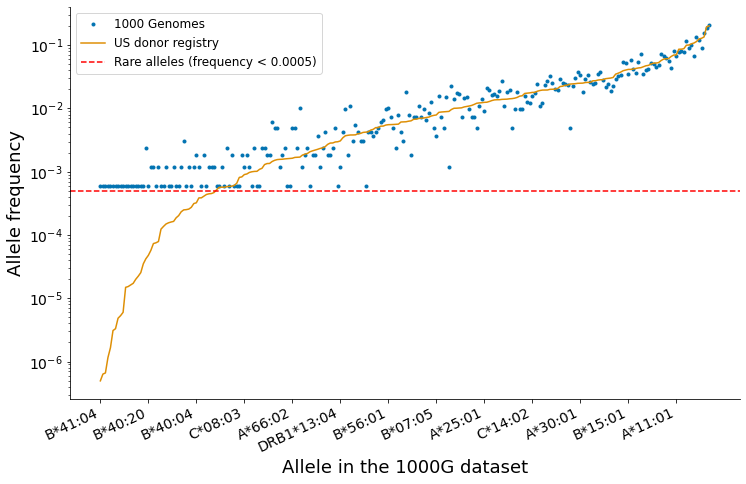

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
df = miscall_population_freq_df[['allele', 'study_freq', 'world_freq']]
df = df.rename(columns={'world_freq' : 'US donor registry', 'study_freq' : '1000 Genomes'})
df = df.sort_values('US donor registry').set_index('allele')

df['1000 Genomes'].plot(ax=ax, style = '.', color=palette_list[0])
df['US donor registry'].plot(ax=ax, color=palette_list[1])

ax.set_ylabel('Allele frequency', size=18)
ax.set_xlabel('Allele in the 1000G dataset', size=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(0, len(df.index)+1, 19), labels=list(df.index)[0::19], rotation=25, ha='right', va='top')
# ax.set_xticks(list(df.index[0::10]))
# # ax.set_xticklabels(df.index[::10], rotation=45)
ax.axhline(y=1/2000, linestyle='--', color='r', label='Rare alleles (frequency < 0.0005)')
ax.legend(prop={'size' : 12})
ax.set_yscale('log')
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.subplots_adjust(bottom=0.2)

#plt.title('Allele frequencies in the 1000G dataset', size=20)
plt.savefig('plots/allele_frequency_comparison.eps')
plt.savefig('paper_plots/FigureS4.eps')

In [20]:
from scipy import stats
stats.ttest_rel(miscall_population_freq_df['study_freq'], miscall_population_freq_df['world_freq'])

Ttest_relResult(statistic=0.9069782190524931, pvalue=0.3653242693701174)

In [21]:
# #sanity check
# count = 0
# hisat_calls = 0
# samples = list()
# for i, row in miscalls_overview_df.iterrows():
#     num_hits = str(row['A']).count('A*02:01')
#     if num_hits == 1:
#         count += num_hits
#         num_pred = str(row['A-Hisatgenotype']).count('A*02:01')
#         if num_pred > 0:
#             hisat_calls += 1
#             samples += [i]
#     elif num_hits == 2:
#         count += num_hits
#         num_pred = str(row['A-Hisatgenotype']).count('A*02:01')
#         hisat_calls += num_pred
#         samples += [i]


## Find number of rare and number of non-rare alleles

In [22]:

print(f"Number of non-rare alleles: {sum(miscall_freq_df[miscall_freq_df['world_freq'] > 1/2000]['count'])}")
print(f"Number of rare alleles: {sum(miscall_freq_df[miscall_freq_df['world_freq'] <= 1/2000]['count'])}")

Number of non-rare alleles: 8220.0
Number of rare alleles: 70.0


## Find top 10 alleles with lowest typing accuracy for each tool.

In [23]:
top_miscall_alleles = list()
for tool in tools:
    if tool == 'STC-seq':
        continue
    top_miscall_alleles += list(miscall_population_freq_df[miscall_population_freq_df['count'] > 10].sort_values(f'{tool}-accuracy').index[0:10])

top_miscall_alleles = set(top_miscall_alleles)
print(len(top_miscall_alleles))
top_miscalls_population_freq_df = miscall_population_freq_df.loc[top_miscall_alleles]
top_miscalls_population_freq_df.sort_values('world_freq').to_csv('result_data/top_miscalled_alleles_freq.csv')
top_miscalls_population_freq_df.sort_values('world_freq', ascending=False).head()

30


,allele,count,Kourami,HLA-LA,Hisatgenotype,STC-seq,Optitype,world_freq,Kourami-accuracy,HLA-LA-accuracy,Hisatgenotype-accuracy,STC-seq-accuracy,Optitype-accuracy,study_freq,freq_diff,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq
1,A*02:01,348.00000,298.00000,326.00000,215.00000,166.00000,345.00000,0.20172,0.85632,0.93678,0.61782,0.47701,0.99138,0.20989,0.00818,0.12223,0.08435,0.26508,0.20955,0.27160
34,A*01:01,113.00000,96.00000,102.00000,88.00000,52.00000,113.00000,0.10813,0.84956,0.90265,0.77876,0.46018,1.00000,0.06815,0.03997,0.04683,0.07137,0.11840,0.07293,0.15883
16,DQB1*03:02,167.00000,110.00000,157.00000,148.00000,69.00000,0.00000,0.10508,0.65868,0.94012,0.88623,0.41317,NaN,0.10072,0.00436,0.03776,0.07493,0.14319,0.18909,0.10349
40,A*24:02,152.00000,126.00000,144.00000,117.00000,76.00000,152.00000,0.10050,0.82895,0.94737,0.76974,0.50000,1.00000,0.09168,0.00882,0.02481,0.17315,0.12935,0.12347,0.08913
0,A*03:01,190.00000,167.00000,179.00000,134.00000,84.00000,189.00000,0.09969,0.87895,0.94211,0.70526,0.44211,0.99474,0.11460,0.01491,0.08309,0.03357,0.10239,0.08029,0.13961


In [24]:
top_miscalls_population_freq_df.sort_values('Hisatgenotype-accuracy', ascending=True)

,allele,count,Kourami,HLA-LA,Hisatgenotype,STC-seq,Optitype,world_freq,Kourami-accuracy,HLA-LA-accuracy,Hisatgenotype-accuracy,STC-seq-accuracy,Optitype-accuracy,study_freq,freq_diff,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq
95,DRB1*03:02,33.00000,32.00000,33.00000,6.00000,23.00000,0.00000,0.01288,0.96970,1.00000,0.18182,0.69697,NaN,0.01990,0.00702,0.06306,0.00011,0.00320,0.01170,0.00038
26,A*31:01,47.00000,40.00000,40.00000,25.00000,19.00000,47.00000,0.02847,0.85106,0.85106,0.53191,0.40426,1.00000,0.02835,0.00013,0.01000,0.03135,0.06803,0.04592,0.02545
65,A*02:06,18.00000,14.00000,17.00000,10.00000,8.00000,12.00000,0.01396,0.77778,0.94444,0.55556,0.44444,0.66667,0.01086,0.00310,0.00073,0.03572,0.02818,0.03310,0.00195
1,A*02:01,348.00000,298.00000,326.00000,215.00000,166.00000,345.00000,0.20172,0.85632,0.93678,0.61782,0.47701,0.99138,0.20989,0.00818,0.12223,0.08435,0.26508,0.20955,0.27160
22,DRB1*03:01,128.00000,110.00000,124.00000,87.00000,72.00000,0.00000,0.08786,0.85938,0.96875,0.67969,0.56250,NaN,0.07720,0.01066,0.06954,0.05635,0.08849,0.07022,0.11410
59,DRB1*14:01,41.00000,39.00000,40.00000,28.00000,21.00000,0.00000,0.02327,0.95122,0.97561,0.68293,0.51220,NaN,0.02473,0.00145,0.01870,0.02210,0.02658,0.01818,0.02731
0,A*03:01,190.00000,167.00000,179.00000,134.00000,84.00000,189.00000,0.09969,0.87895,0.94211,0.70526,0.44211,0.99474,0.11460,0.01491,0.08309,0.03357,0.10239,0.08029,0.13961
75,DRB1*12:01,42.00000,30.00000,37.00000,30.00000,21.00000,0.00000,0.02014,0.71429,0.88095,0.71429,0.50000,NaN,0.02533,0.00519,0.03728,0.02038,0.01364,0.01148,0.01747
40,A*24:02,152.00000,126.00000,144.00000,117.00000,76.00000,152.00000,0.10050,0.82895,0.94737,0.76974,0.50000,1.00000,0.09168,0.00882,0.02481,0.17315,0.12935,0.12347,0.08913
34,A*01:01,113.00000,96.00000,102.00000,88.00000,52.00000,113.00000,0.10813,0.84956,0.90265,0.77876,0.46018,1.00000,0.06815,0.03997,0.04683,0.07137,0.11840,0.07293,0.15883


## Detect population bias

Split into two groups: 
1) Rare in CAU and common in one other group
2) COmmon in CAU

In [25]:
non_cau_df = miscall_population_freq_df.query("AFA_freq > 0.005 or API_freq > 0.005 or NAM_freq > 0.0005 or HIS_freq > 0.0005" )
non_cau_df = non_cau_df[non_cau_df['CAU_freq'] < 1/2000]
print(len(non_cau_df))
non_cau_df['frequency_group'] = 'Rare in CAU, but common in another group'
non_cau_df.head()

67


,allele,count,Kourami,HLA-LA,Hisatgenotype,STC-seq,Optitype,world_freq,Kourami-accuracy,HLA-LA-accuracy,Hisatgenotype-accuracy,STC-seq-accuracy,Optitype-accuracy,study_freq,freq_diff,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq,frequency_group
27,B*15:10,18.00000,17.00000,18.00000,18.00000,12.00000,18.00000,0.00692,0.94444,1.00000,1.00000,0.66667,1.00000,0.01086,0.00393,0.03488,0.00032,0.00169,0.00477,0.00035,"Rare in CAU, but common in another group"
78,A*66:02,8.00000,6.00000,7.00000,7.00000,3.00000,7.00000,0.00163,0.75000,0.87500,0.87500,0.37500,0.87500,0.00483,0.00319,0.00892,0.00003,0.00029,0.00067,0.00003,"Rare in CAU, but common in another group"
79,B*78:01,3.00000,3.00000,3.00000,3.00000,1.00000,3.00000,0.00189,1.00000,1.00000,1.00000,0.33333,1.00000,0.00181,0.00008,0.00951,0.00004,0.00056,0.00146,0.00005,"Rare in CAU, but common in another group"
82,A*74:01,25.00000,23.00000,25.00000,25.00000,14.00000,25.00000,0.01073,0.92000,1.00000,1.00000,0.56000,1.00000,0.01508,0.00434,0.05470,0.00132,0.00318,0.00682,0.00018,"Rare in CAU, but common in another group"
86,B*39:10,4.00000,4.00000,4.00000,4.00000,1.00000,4.00000,0.00159,1.00000,1.00000,1.00000,0.25000,1.00000,0.00241,0.00082,0.00841,0.00004,0.00051,0.00064,0.00013,"Rare in CAU, but common in another group"


In [26]:
cau_df = miscall_population_freq_df[miscall_population_freq_df['CAU_freq'] >= 0.005]
cau_df['frequency_group'] = 'Common in CAU'
print(len(cau_df))
cau_df.head()

97


/tmp/ipykernel_2392975/1822834491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cau_df['frequency_group'] = 'Common in CAU'


,allele,count,Kourami,HLA-LA,Hisatgenotype,STC-seq,Optitype,world_freq,Kourami-accuracy,HLA-LA-accuracy,Hisatgenotype-accuracy,STC-seq-accuracy,Optitype-accuracy,study_freq,freq_diff,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq,frequency_group
0,A*03:01,190.00000,167.00000,179.00000,134.00000,84.00000,189.00000,0.09969,0.87895,0.94211,0.70526,0.44211,0.99474,0.11460,0.01491,0.08309,0.03357,0.10239,0.08029,0.13961,Common in CAU
1,A*02:01,348.00000,298.00000,326.00000,215.00000,166.00000,345.00000,0.20172,0.85632,0.93678,0.61782,0.47701,0.99138,0.20989,0.00818,0.12223,0.08435,0.26508,0.20955,0.27160,Common in CAU
2,B*07:02,131.00000,110.00000,127.00000,128.00000,83.00000,128.00000,0.08626,0.83969,0.96947,0.97710,0.63359,0.97710,0.07901,0.00725,0.07274,0.02934,0.09682,0.05785,0.12466,Common in CAU
3,B*57:01,48.00000,33.00000,46.00000,45.00000,12.00000,48.00000,0.02567,0.68750,0.95833,0.93750,0.25000,1.00000,0.02895,0.00328,0.00701,0.03093,0.02695,0.01409,0.03500,Common in CAU
4,C*07:02,197.00000,160.00000,189.00000,176.00000,89.00000,197.00000,0.12540,0.81218,0.95939,0.89340,0.45178,1.00000,0.11882,0.00658,0.07213,0.14325,0.14589,0.12177,0.13652,Common in CAU


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


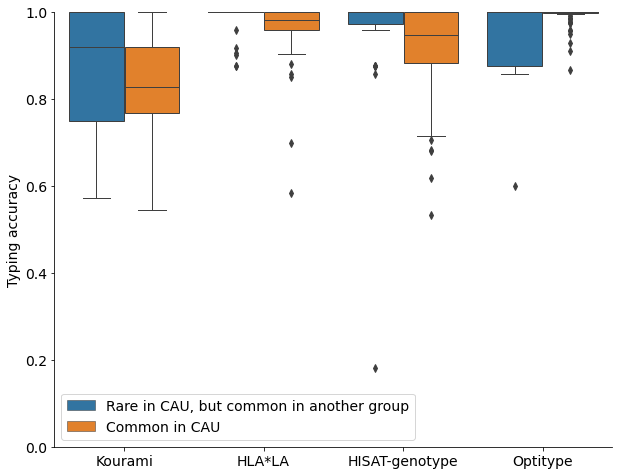

In [27]:
cau_bias_analysis_df = pd.concat([non_cau_df, cau_df])

#Remove alleles, which are only found less than 5 times in the dataset
cau_bias_analysis_df = cau_bias_analysis_df[cau_bias_analysis_df['count'] > 5]


cau_bias_analysis_df = cau_bias_analysis_df.drop(columns=tools)
rename_dict = {f'{tool}-accuracy' : tool for tool in tools}
cau_bias_analysis_df = cau_bias_analysis_df.rename(columns=rename_dict)
cau_bias_analysis_df = cau_bias_analysis_df.rename(columns={'Hisatgenotype' : 'HISAT-genotype', 'HLA-LA' : 'HLA*LA'})
cau_bias_long_df = pd.melt(cau_bias_analysis_df, id_vars='frequency_group', value_vars=['Kourami', 'HLA*LA', 'HISAT-genotype', 'Optitype'])
cau_bias_long_df = cau_bias_long_df.rename(columns={'variable' : 'Tool', 'value' : 'Typing accuracy'})

fig, ax = plt.subplots(figsize=(10,8))
ax.set_ylim(0,1)

# Draw a nested violinplot and split the violins for easier comparison
sns.boxplot(data=cau_bias_long_df, x="Tool", y="Typing accuracy", hue="frequency_group", linewidth=1, ax=ax)
ax.legend(loc='lower right')
sns.despine(top=True, right=True)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Typing accuracy", size=14)

ax.xaxis.label.set_size(20)
ax.legend(loc='lower left', prop={'size' : 14})

fig.savefig('plots/typing_accuracy_by_population.eps')
plt.savefig('paper_plots/FigureS6.eps')

In [28]:
#Create long table for plotting overview of miscalls vs correct calls
# call_counts = [] 
# for tool in tools:
#     tool_counts = {'miscall' : [], 'correct_call' : []}

#     for allele, row in miscall_freq_df.iterrows():

#         tool_counts['correct_call'] += [row['world_freq']] * int(row[tool]) 
#         tool_counts['miscall'] += [row['world_freq']] * int(row['count'] - row[tool])

#     df = pd.DataFrame.from_dict(tool_counts, orient='index').T
#     #df = df.rename(columns={'miscall'})
#     df = pd.melt(frame = df,
#                 #id_vars = 'Patient',
#                 value_vars = ['miscall', 'correct_call'],
#                 var_name = 'typing_result',
#                 value_name = 'freq')
#     df['tool'] = tool

#     call_counts += [df]

# miscall_freq_long_df = pd.concat(call_counts)
# miscall_freq_long_df.head()

# import seaborn as sns
# violin_df = top_miscalls_population_freq_df[['world_freq', 'AFA_freq', 'API_freq', 'NAM_freq', 'HIS_freq', 'CAU_freq']]

# fig, ax = plt.subplots(figsize=(10,8))

# violin_df.boxplot(ax=ax)
# ax.set_yscale('log')

# Are there any systematic errors across all tools?
e.g due to rare alleles or detected errors in the 1000G dataset.

In [29]:
#Calculate typing accuracy of:
# 1) Rare alleles
# 2) Alleles with a typing accuracy of above 1%

rare_df = miscall_freq_df[miscall_freq_df['world_freq'] < 1/2000]
frequent_df = miscall_freq_df[miscall_freq_df['world_freq'] >= 1/2000]

rare_typing_accuracy_dict = dict()

for tool in ['Kourami', 'HLA-LA', 'Hisatgenotype']:
    rare_typing_accuracy_dict[f'{tool} typing accuracy'] = dict()
    rare_typing_accuracy_dict[f'{tool} typing accuracy']['Rare'] = sum(rare_df[tool]) / sum(rare_df['count'])
    rare_typing_accuracy_dict[f'{tool} typing accuracy']['Common'] = sum(frequent_df[tool]) / sum(frequent_df['count'])

rare_typing_accuracy_dict['Optitype typing accuracy'] = dict()
rare_typing_accuracy_dict['Optitype typing accuracy']['Rare'] = sum(rare_df['Optitype']) / sum(rare_df[~rare_df['allele'].str.startswith('D')]['count'])
rare_typing_accuracy_dict['Optitype typing accuracy']['Common'] = sum(frequent_df['Optitype']) / sum(frequent_df[~frequent_df['allele'].str.startswith('D')]['count'])

rare_typing_accuracy_dict['Number of unique alleles'] = dict()
rare_typing_accuracy_dict['Number of unique alleles']['Rare'] = len(rare_df)
rare_typing_accuracy_dict['Number of unique alleles']['Common'] = len(frequent_df)
rare_typing_accuracy_dict['Number of Alleles'] = dict()
rare_typing_accuracy_dict['Number of Alleles']['Rare'] = int(sum(rare_df['count']))
rare_typing_accuracy_dict['Number of Alleles']['Common'] = int(sum(frequent_df['count']))

rare_frequent_typing_acc_df = pd.DataFrame(rare_typing_accuracy_dict)
rare_frequent_typing_acc_df.to_csv('result_data/typing_accuracy_rare_vs_frequent.csv')
rare_frequent_typing_acc_df.to_csv('paper_tables/TableS4.csv')
rare_frequent_typing_acc_df


,Kourami typing accuracy,HLA-LA typing accuracy,Hisatgenotype typing accuracy,Optitype typing accuracy,Number of unique alleles,Number of Alleles
Rare,0.88571,1.00000,0.61429,0.92063,47,70
Common,0.83674,0.96265,0.89063,0.98778,203,8220


## Analysis of typing accuracy correlated with general allele frequency

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


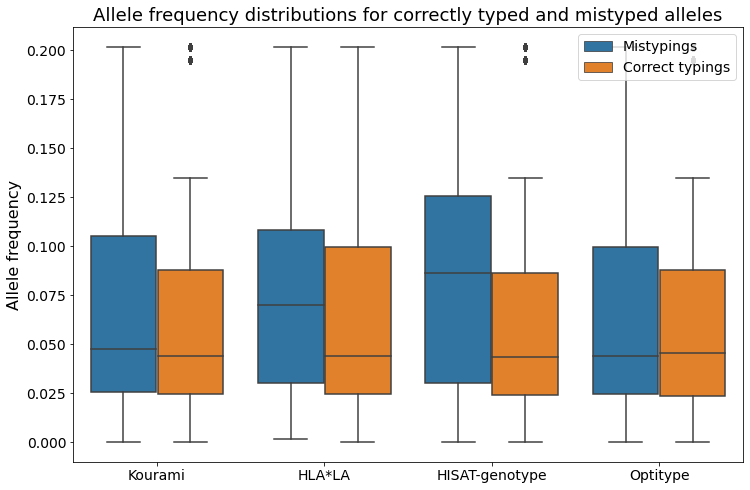

In [30]:
#Create long table for plotting overview of miscalls vs correct calls
call_counts = [] 
for tool, tool_name in zip(tools, ['Kourami', 'HLA*LA', 'HISAT-genotype', 'Optitype']):
    tool_counts = {'Mistypings' : [], 'Correct typings' : []}

    for allele, row in miscall_freq_df.iterrows():

        tool_counts['Correct typings'] += [row['world_freq']] * int(row[tool]) 
        tool_counts['Mistypings'] += [row['world_freq']] * int(row['count'] - row[tool])

    df = pd.DataFrame.from_dict(tool_counts, orient='index').T
    df.rename
    df = pd.melt(frame = df,
                #id_vars = 'Patient',
                value_vars = ['Mistypings', 'Correct typings'],
                var_name = 'typing_result',
                value_name = 'freq')
    df['tool'] = tool_name

    call_counts += [df]

miscall_freq_long_df = pd.concat(call_counts)



#Plot miscalls:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(ax = ax,
               data = miscall_freq_long_df,
               x = 'tool',
               y = 'freq',
               hue = 'typing_result')
               

ax.legend(loc='upper right')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Allele frequency", size=16)
ax.set_xlabel("", size=14)
ax.xaxis.label.set_size(20)
ax.legend(loc='upper right', prop={'size' : 14})

plt.title('Allele frequency distributions for correctly typed and mistyped alleles', size=18)

fig.savefig('plots/allele_frequency_bias.eps')
plt.savefig('paper_plots/FigureS5.eps')


In [31]:
# fig, ax = plt.subplots(1, 1, figsize=(16,12))

# x = 'world_freq'

# ax1 = miscall_freq_df.plot(kind='scatter', x=x, y='Kourami-accuracy', label='Kourami', color=palette_list[0], ax=ax)    
# ax2 = miscall_freq_df.plot(kind='scatter', x=x, y='HLA-LA-accuracy', label='HLA*LA',color=palette_list[1], ax=ax)    
# ax3 = miscall_freq_df.plot(kind='scatter', x=x, y='Hisatgenotype-accuracy', label='HISAT_genotype',color=palette_list[2], ax=ax)
# #ax4 = miscall_freq_df.plot(kind='scatter', x=x, y='STC-seq-accuracy', label='STC-seq',color=palette_list[3], ax=ax)
# ax5 = miscall_freq_df.plot(kind='scatter', x=x, y='Optitype-accuracy', label='Optitype',color=palette_list[4], ax=ax)
# ax.set_xscale('log')


## Analysis of alleles, which are consistently miscalled in the 1000G dataset. - can we find errors in the 2014 dataset?

In [32]:
allele_pred_dict = dict()

for sample in gold_standard_df.index:
    for locus in gold_standard_df.columns:
        allele_pred_dict[f'{sample}_{locus}'] = dict()
        for tool in full_typing_dict[resolution]:
            if 'prediction' in full_typing_dict[resolution][tool][locus][sample]:
                allele_pred_dict[f'{sample}_{locus}']['reference'] = full_typing_dict[resolution][tool][locus][sample]['reference']
                allele_pred_dict[f'{sample}_{locus}'][tool] = full_typing_dict[resolution][tool][locus][sample]['prediction']
                allele_pred_dict[f'{sample}_{locus}'][f'{tool}_wrong_calls'] =  full_typing_dict[resolution][tool][locus][sample]['miscalls']
            else:
                allele_pred_dict[f'{sample}_{locus}'][tool]  = ''
                allele_pred_dict[f'{sample}_{locus}'][f'{tool}_wrong_calls'] = 0

wrong_calls_df = pd.DataFrame(allele_pred_dict).T

#Add identifier to see, if 3/4 tools agree on typing, which differs from the reference (class I) or 2/3 for class II
sample_locus_disagreements = list()
for sample_locus, row in wrong_calls_df.iterrows():
    if sample_locus.endswith('D'):
        if (row['Kourami_wrong_calls'] > 0) + (row['HLA-LA_wrong_calls'] > 0) + (row['Hisatgenotype_wrong_calls'] > 0) >= 2:
            unique_predictions = {str(sorted(row['Kourami'])), str(sorted(row['Hisatgenotype'])), str(sorted(row['HLA-LA']))}
            if len(unique_predictions) < 2:
                sample_locus_disagreements += [sample_locus]

    else:
        if (row['Kourami_wrong_calls'] > 0) + (row['HLA-LA_wrong_calls'] > 0) + (row['Hisatgenotype_wrong_calls'] > 0) + (row['Optitype_wrong_calls'] > 0) >= 3:
            unique_predictions = {str(sorted(row['Kourami'])), str(sorted(row['Hisatgenotype'])), str(sorted(row['HLA-LA'])), str(sorted(row['Optitype']))}
            if len(unique_predictions) < 3:
                sample_locus_disagreements += [sample_locus]

In [33]:
wrong_calls_df[wrong_calls_df.index.isin(sample_locus_disagreements)]

,reference,Kourami,Kourami_wrong_calls,HLA-LA,HLA-LA_wrong_calls,Optitype,Optitype_wrong_calls,Hisatgenotype,Hisatgenotype_wrong_calls,STC-seq,STC-seq_wrong_calls
NA18507_DRB1,"[[DRB1*13:02], [DRB1*13:02]]","[[DRB1*13:02], [DRB1*08:04]]",1,"[[DRB1*08:04], [DRB1*13:02]]",1,,2,"[[DRB1*13:02], [DRB1*08:04]]",1,"[[DRB1*08:04], [DRB1*13:02]]",1
NA18861_DQB1,"[[DQB1*06:03], [DQB1*04:02]]",,2,"[[DQB1*04:02], [DQB1*05:03]]",1,,2,"[[DQB1*04:02], [DQB1*05:03]]",1,"[[DQB1*05:03], [DQB1*05:03]]",2
NA19130_DRB1,"[[DRB1*08:04], [DRB1*08:04]]","[[DRB1*13:03], [DRB1*08:04]]",1,"[[DRB1*08:04], [DRB1*13:03]]",1,,2,"[[DRB1*08:04], [DRB1*13:03]]",1,"[[DRB1*08:04], [DRB1*08:10]]",1
NA19131_A,"[[A*66:02], [A*68:02]]","[[A*66:03], [A*68:02]]",1,"[[A*25:18], [A*68:02]]",1,"[[A*68:02], [A*66:03]]",1,"[[A*66:03], [A*68:02]]",1,"[[A*68:31], [A*68:31]]",2
HG00334_DQB1,"[[DQB1*03:01], [DQB1*04:02]]",,2,"[[DQB1*04:02], [DQB1*04:02]]",1,,2,"[[DQB1*04:02], [DQB1*04:02]]",1,,2
HG00610_A,"[[A*02:10], [A*02:06]]","[[A*02:10], [A*02:10]]",1,"[[A*02:10], [A*02:06]]",0,"[[A*02:10], [A*02:10]]",1,"[[A*02:10], [A*02:10]]",1,"[[A*02:10], [A*02:10]]",1
HG00625_A,"[[A*11:02], [A*11:02]]","[[A*11:02], [A*11:50]]",1,"[[A*11:50], [A*11:02]]",1,"[[A*11:02], [A*11:02]]",0,"[[A*11:02], [A*11:50]]",1,,2


In [34]:
# Perform the same analysis for the 2014 dataset:

#Load and reformat dataset:
gs_2014_df = pd.read_pickle('../reference_data/1000G_2014_cleaned.pkl')
gs_2014_df.head()

,A,A.1,B,B.1,C,C.1,DRB1,DRB1.1,DQB1,DQB1.1
id,,,,,,,,,,
NA06985,[A*03:01],[A*02:01],[B*07:02:01],[B*57:01],[C*07:02],[C*06:02:01:01],[DRB1*15:01],[DRB1*15:01],[DQB1*06:02:01],[DQB1*06:02:01]
NA06986,[A*03:01],"[A*32:01:01, A*32:01:02]","[B*44:03:01, B*44:03:03, B*44:03:04]","[B*44:03:01, B*44:03:03, B*44:03:04]",[C*04:01],[C*16:01],[DRB1*07:01],[DRB1*07:01],[DQB1*02:01],[DQB1*02:01]
NA06994,[A*02:01],"[A*32:01:01, A*32:01:02]",[B*40:02],[B*08:01],[C*02:02:02],"[C*07:01, C*07:06]",[DRB1*01:01],[DRB1*04:04],[DQB1*05:01],[DQB1*03:02]
NA07000,[A*02:01],[A*68:01:02],[B*44:02],[B*40:01],"[C*03:03, C*03:04]",[C*07:04],[DRB1*03:01],"[DRB1*11:01:01, DRB1*11:01:08]",[DQB1*02:01],[DQB1*03:01]
NA07037,[A*30:01],[A*31:01],[B*15:10],[B*40:01],[C*03:04:02],[C*03:04],[DRB1*04:04],[DRB1*13:02],[DQB1*03:02],[DQB1*06:04]


In [35]:
allele_pred_dict = dict()

for sample in gold_standard_df.index:
    if sample not in list(gs_2014_df.index):
        continue
    for locus in gold_standard_df.columns:
        allele_pred_dict[f'{sample}_{locus}'] = dict()

        #Find reference typing in P group resolution:
        reference_typing_2014 = [gs_2014_df[gs_2014_df.index == sample].iloc[0][f'{locus}'], gs_2014_df[gs_2014_df.index == sample].iloc[0][f'{locus}.1']]

        for tool in full_typing_dict[resolution]:            
            if full_typing_dict[resolution][tool][locus][sample]['prediction'] != '':
                tool_pred = full_typing_dict[resolution][tool][locus][sample]['prediction']
                num_correct_hits, correct_call, pred_call = validate_call(reference_typing_2014, tool_pred)

                allele_pred_dict[f'{sample}_{locus}']['reference'] = correct_call
                allele_pred_dict[f'{sample}_{locus}'][tool] = pred_call

                #Count number of "wrong calls" in the 2014 dataset:
                num_wrong_calls = 2 - num_correct_hits
                allele_pred_dict[f'{sample}_{locus}'][f'{tool}_wrong_calls'] = num_wrong_calls
            else:
                allele_pred_dict[f'{sample}_{locus}'][tool]  = ''
                allele_pred_dict[f'{sample}_{locus}'][f'{tool}_wrong_calls'] = 0

wrong_calls_df = pd.DataFrame(allele_pred_dict).T

#Add identifier to see, if 3/4 tools agree on typing, which differs from the reference (class I) or 2/3 for class II
sample_locus_disagreements = list()
for sample_locus, row in wrong_calls_df.iterrows():
    if sample_locus.endswith('D'):
        if (row['Kourami_wrong_calls'] > 0) + (row['HLA-LA_wrong_calls'] > 0) + (row['Hisatgenotype_wrong_calls'] > 0) >= 2:
            unique_predictions = {str(sorted(row['Kourami'])), str(sorted(row['Hisatgenotype'])), str(sorted(row['HLA-LA']))}
            if len(unique_predictions) < 2:
                sample_locus_disagreements += [sample_locus]

    else:
        if (row['Kourami_wrong_calls'] > 0) + (row['HLA-LA_wrong_calls'] > 0) + (row['Hisatgenotype_wrong_calls'] > 0) + (row['Optitype_wrong_calls'] > 0) >= 3:
            unique_predictions = {str(sorted(row['Kourami'])), str(sorted(row['Hisatgenotype'])), str(sorted(row['HLA-LA'])), str(sorted(row['Optitype']))}
            if len(unique_predictions) < 3:
                sample_locus_disagreements += [sample_locus]

#Find disagreements with 2014:
disagreements_with_2014_dataset = wrong_calls_df[wrong_calls_df.index.isin(sample_locus_disagreements)].reset_index()
disagreements_with_2014_dataset['sample_id'] = disagreements_with_2014_dataset['index'].str.slice(0,7)
disagreements_with_2014_dataset = disagreements_with_2014_dataset.drop(columns=['index', 'STC-seq'])
disagreements_with_2014_dataset.to_csv('result_data/disagreements_with_2014.csv')
disagreements_with_2014_dataset

,reference,Kourami,Kourami_wrong_calls,HLA-LA,HLA-LA_wrong_calls,Optitype,Optitype_wrong_calls,Hisatgenotype,Hisatgenotype_wrong_calls,STC-seq_wrong_calls,sample_id
0,"[[B*40:02], [B*27:03, B*27:52, B*27:09, B*27:51]]","[[B*27:05], [B*40:02]]",1,"[[B*27:05], [B*40:02]]",1,"[[B*40:02], [B*27:05]]",1,"[[B*27:05], [B*40:02]]",1,1,NA11832
1,"[[B*27:03], [B*57:01]]","[[B*57:01], [B*27:05]]",1,"[[B*27:05], [B*57:01]]",1,"[[B*57:01], [B*27:05]]",1,"[[B*27:05], [B*57:01]]",1,1,NA11840
2,"[[B*07:02], [B*27:03, B*27:09, B*27:52]]","[[B*07:02], [B*27:05]]",1,"[[B*27:05], [B*07:02]]",1,"[[B*27:05], [B*07:02]]",1,"[[B*07:02], [B*27:05]]",1,1,NA12005
3,"[[B*40:01], [B*40:01]]","[[B*35:03], [B*40:01]]",1,"[[B*35:03], [B*40:01]]",1,"[[B*35:03], [B*40:01]]",1,"[[B*40:01], [B*35:03]]",1,2,NA12058
4,"[[C*03:04], [C*03:04]]","[[C*03:04], [C*04:01]]",1,"[[C*03:04], [C*04:01]]",1,"[[C*03:04], [C*04:01]]",1,"[[C*03:04], [C*04:01]]",1,2,NA12058
5,"[[C*15:02], [C*06:02]]","[[C*15:02], [C*06:06]]",1,"[[C*06:06], [C*15:02]]",1,"[[C*15:02], [C*06:06]]",1,"[[C*15:02], [C*06:06]]",1,1,NA12156
6,"[[B*40:01], [None]]","[[B*44:02], [B*40:01]]",1,"[[B*40:01], [B*44:02]]",1,"[[B*40:01], [B*44:02]]",1,"[[B*40:01], [B*44:02]]",1,1,NA12249
7,"[[B*15:03, B*15:01], [B*15:26, B*15:12, B*15:01]]","[[B*15:01], [B*51:01]]",1,"[[B*15:01], [B*51:01]]",1,"[[B*51:01], [B*15:01]]",1,"[[B*15:01], [B*51:01]]",1,0,NA12287
8,"[[DRB1*13:02], [DRB1*13:02]]","[[DRB1*13:02], [DRB1*08:04]]",1,"[[DRB1*08:04], [DRB1*13:02]]",1,,0,"[[DRB1*13:02], [DRB1*08:04]]",1,1,NA18507
9,"[[DRB1*15:03], [DRB1*13:01]]","[[DRB1*13:02], [DRB1*15:03]]",1,"[[DRB1*13:02], [DRB1*15:03]]",1,,0,"[[DRB1*15:03], [DRB1*13:02]]",1,2,NA19093


In [36]:
#Disagreements with the 1000G dataset

allele_pred_dict = dict()

for sample in gold_standard_df.index:
    for locus in gold_standard_df.columns:
        allele_pred_dict[f'{sample}_{locus}'] = dict()

        #Find reference typing in P group resolution:
        reference_typing_1000G = gold_standard_df.loc[sample, locus]

        for tool in full_typing_dict[resolution]:            
            if full_typing_dict[resolution][tool][locus][sample]['prediction'] != '':
                tool_pred = full_typing_dict[resolution][tool][locus][sample]['prediction']
                num_correct_hits, correct_call, pred_call = validate_call(reference_typing_1000G, tool_pred)

                allele_pred_dict[f'{sample}_{locus}']['reference'] = correct_call
                allele_pred_dict[f'{sample}_{locus}'][tool] = pred_call

                #Count number of "wrong calls" in the 2014 dataset:
                num_wrong_calls = 2 - num_correct_hits
                allele_pred_dict[f'{sample}_{locus}'][f'{tool}_wrong_calls'] = num_wrong_calls
            else:
                allele_pred_dict[f'{sample}_{locus}'][tool]  = ''
                allele_pred_dict[f'{sample}_{locus}'][f'{tool}_wrong_calls'] = 0

wrong_calls_df = pd.DataFrame(allele_pred_dict).T

#Add identifier to see, if 3/4 tools agree on typing, which differs from the reference (class I) or 2/3 for class II
sample_locus_disagreements = list()
for sample_locus, row in wrong_calls_df.iterrows():
    if sample_locus.endswith('D'):
        if (row['Kourami_wrong_calls'] > 0) + (row['HLA-LA_wrong_calls'] > 0) + (row['Hisatgenotype_wrong_calls'] > 0) >= 2:
            sample_locus_disagreements += [sample_locus]
            # unique_predictions = {str(sorted(row['Kourami'])), str(sorted(row['Hisatgenotype'])), str(sorted(row['HLA-LA']))}
            # if len(unique_predictions) < 2:
            #     sample_locus_disagreements += [sample_locus]

    else:
        if (row['Kourami_wrong_calls'] > 0) + (row['HLA-LA_wrong_calls'] > 0) + (row['Hisatgenotype_wrong_calls'] > 0) + (row['Optitype_wrong_calls'] > 0) >= 3:
            sample_locus_disagreements += [sample_locus]
            # unique_predictions = {str(sorted(row['Kourami'])), str(sorted(row['Hisatgenotype'])), str(sorted(row['HLA-LA'])), str(sorted(row['Optitype']))}
            # if len(unique_predictions) < 3:
            #     sample_locus_disagreements += [sample_locus]

#Find disagreements with the 1000G dataset
disagreements_with_1000G_dataset = wrong_calls_df[wrong_calls_df.index.isin(sample_locus_disagreements)].reset_index()
disagreements_with_1000G_dataset['sample_id'] = disagreements_with_1000G_dataset['index'].str.slice(0,7)
disagreements_with_1000G_dataset = disagreements_with_1000G_dataset.drop(columns=['index', 'STC-seq'])
disagreements_with_1000G_dataset.to_csv('result_data/disagreements_with_1000G.csv')
disagreements_with_1000G_dataset.to_csv('paper_tables/TableS6.csv') 
disagreements_with_1000G_dataset

,reference,Kourami,Kourami_wrong_calls,HLA-LA,HLA-LA_wrong_calls,Optitype,Optitype_wrong_calls,Hisatgenotype,Hisatgenotype_wrong_calls,STC-seq_wrong_calls,sample_id
0,"[[A*23:01], [A*03:01]]","[[A*02:110], [A*29:18]]",2,"[[A*23:04], [A*03:123]]",2,"[[A*02:01], [A*03:01]]",1,"[[A*02:95], [A*23:01]]",1,1,NA12275
1,"[[B*14:01], [B*07:02]]","[[B*07:202], [B*44:46]]",2,"[[B*44:46], [B*81:01]]",2,"[[B*14:01], [B*40:01]]",1,"[[B*07:02], [B*14:01]]",0,0,NA12275
2,"[[C*08:02], [C*07:02]]","[[C*03:86], [C*07:51]]",2,"[[C*16:07], [C*03:04]]",2,"[[C*03:04], [C*07:02]]",1,"[[C*08:94], [C*16:01]]",2,2,NA12275
3,"[[DRB1*12:01], [DRB1*15:01]]","[[DRB1*13:02], [DRB1*15:01]]",1,"[[DRB1*13:02], [DRB1*15:01]]",1,,0,"[[DRB1*13:02], [DRB1*12:03]]",2,1,NA12275
4,"[[DQB1*03:01], [DQB1*06:02]]","[[DQB1*06:04], [DQB1*06:02]]",1,"[[DQB1*03:01], [DQB1*06:04]]",1,,0,"[[DQB1*06:04], [DQB1*06:02]]",1,1,NA12275
5,"[[DRB1*13:02], [DRB1*13:02]]","[[DRB1*13:02], [DRB1*08:04]]",1,"[[DRB1*08:04], [DRB1*13:02]]",1,,0,"[[DRB1*13:02], [DRB1*08:04]]",1,1,NA18507
6,"[[DRB1*08:04], [DRB1*08:04]]","[[DRB1*13:03], [DRB1*08:04]]",1,"[[DRB1*08:04], [DRB1*13:03]]",1,,0,"[[DRB1*08:04], [DRB1*13:03]]",1,1,NA19130
7,"[[A*66:02], [A*68:02]]","[[A*66:03], [A*68:02]]",1,"[[A*25:18], [A*68:02]]",1,"[[A*68:02], [A*66:03]]",1,"[[A*66:03], [A*68:02]]",1,2,NA19131
8,"[[B*53:01], [B*58:02]]",,0,"[[B*53:01], [B*58:01]]",1,"[[B*53:01], [B*53:01]]",1,"[[B*53:01], [B*58:01]]",1,1,NA19371
9,"[[A*02:83, A*02:43, A*02:01], [A*29:02]]","[[A*29:37], [A*02:01]]",1,"[[A*02:01], [A*29:37]]",1,"[[A*02:01], [A*29:02]]",0,"[[A*29:02], [A*29:02]]",1,0,NA19440


In [37]:
Counter([superpop_conversion_dict[pop_conversion_dict[sample]] for sample in disagreements_with_1000G_dataset['sample_id']])

Counter({'EUR': 24, 'AFR': 7, 'AMR': 9, 'EAS': 14})

# Mistakes by population group

In [38]:
#Find number of samples in each population group:
pop_count_list = [superpop_conversion_dict[pop_conversion_dict[sample_id]] for sample_id in gold_standard_df.index]
pop_group_count_dict = Counter(pop_count_list)

#Reformat json structure into pandas Dataframe
pop_miscalls_dict = dict()
for tool, locus_dict in full_typing_dict['P group'].items():
    for locus, sample_dict in locus_dict.items():
        for sample_id, sample_data in sample_dict.items():
            pop_group = superpop_conversion_dict[pop_conversion_dict[sample_id]]
            if (tool, pop_group) not in pop_miscalls_dict:
                pop_miscalls_dict[(tool, pop_group)] = dict()
            if locus not in pop_miscalls_dict[(tool, pop_group)]:
                pop_miscalls_dict[(tool, pop_group)][locus] = 0

            #Add number of miscalls for the specific population group
            pop_miscalls_dict[(tool, pop_group)][locus] += sample_data['miscalls']

    for pop_group in pop_group_count_dict.keys():
        pop_miscalls_dict[(tool, pop_group)]['HLA-I'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['A', 'B', 'C']])
        pop_miscalls_dict[(tool, pop_group)]['HLA-II'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['DRB1', 'DQB1']])
        pop_miscalls_dict[(tool, pop_group)]['Total'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['HLA-I', 'HLA-II']])


pop_accuracy_dict = dict()
for (tool, pop_group), locus_dict in pop_miscalls_dict.items():

    pop_accuracy_dict[(tool, pop_group)] = dict()

    for locus, miscalls in locus_dict.items():
        if locus == 'HLA-I':
            pop_count = pop_group_count_dict[pop_group] * 6
        elif locus == 'HLA-II':
            pop_count = pop_group_count_dict[pop_group] * 4
        elif locus == 'Total':
            pop_count = pop_group_count_dict[pop_group] * 10
        else:
            pop_count = pop_group_count_dict[pop_group] * 2
        
        pop_accuracy_dict[(tool, pop_group)][locus] = (pop_count - miscalls) / pop_count

pop_accuracy_df = pd.DataFrame(pop_accuracy_dict)
pop_accuracy_df.to_csv('paper_tables/TableS5.csv')

pop_accuracy_df

Kourami                          HLA-LA                          \
           EUR     AFR     AMR     EAS     EUR     AFR     AMR     EAS   
A      0.85735 0.86364 0.87562 0.80198 0.93676 0.94118 0.91791 0.89109   
B      0.76618 0.70588 0.84577 0.85644 0.97647 0.97059 0.98507 0.99010   
C      0.81912 0.73529 0.90547 0.86634 0.96176 0.96257 0.99005 0.98515   
DRB1   0.96765 0.95455 0.96766 0.96040 0.97941 0.97594 0.97512 0.99010   
DQB1   0.72500 0.87166 0.88060 0.39604 0.95735 0.98128 0.97264 0.88614   
HLA-I  0.81422 0.76827 0.87562 0.84158 0.95833 0.95811 0.96434 0.95545   
HLA-II 0.84632 0.91310 0.92413 0.67822 0.96838 0.97861 0.97388 0.93812   
Total  0.82706 0.82620 0.89502 0.77624 0.96235 0.96631 0.96816 0.94851   

       Optitype                         Hisatgenotype                          \
            EUR     AFR     AMR     EAS           EUR     AFR     AMR     EAS   
A       0.99412 0.99198 0.98756 0.97030       0.82206 0.87701 0.75622 0.76238   
B       0.99118 0.96524 0.97015 1.00000       0.92500 0.94385 0.92289 0.96040   
C       0.98824 0.99465 0.99254 0.98515       0.93676 0.92781 0.93035 0.91089   
DRB1    0.00000 0.00000 0.00000 0.00000       0.90441 0.82620 0.89552 0.91584   
DQB1    0.00000 0.00000 0.00000 0.00000       0.88382 0.96791 0.92786 0.77228   
HLA-I   0.99118 0.98396 0.98342 0.98515       0.89461 0.91622 0.86982 0.87789   
HLA-II  0.00000 0.00000 0.00000 0.00000       0.89412 0.89706 0.91169 0.84406   
Total   0.59471 0.59037 0.59005 0.59109       0.89441 0.90856 0.88657 0.86436   

       STC-seq                          
           EUR     AFR     AMR     EAS  
A      0.52941 0.65241 0.39303 0.45050  
B      0.49412 0.55882 0.35323 0.44554  
C      0.47059 0.57219 0.34826 0.42079  
DRB1   0.64118 0.77807 0.48507 0.58911  
DQB1   0.46176 0.74332 0.44279 0.14851  
HLA-I  0.49804 0.59447 0.36484 0.43894  
HLA-II 0.55147 0.76070 0.46393 0.36881  
Total  0.51941 0.66096 0.40448 0.41089

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


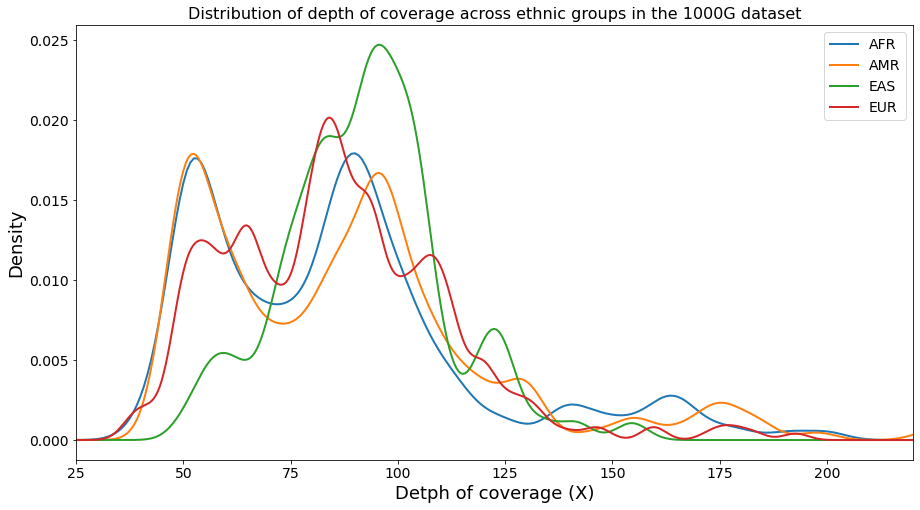

In [39]:
#Plot sequence coverage per population:

cov_df = pd.read_csv('result_data/sample_depth.csv', index_col=[0])

cov_df['Ethnic Group'] = [superpop_conversion_dict[pop_conversion_dict[sample]] for sample in cov_df.index]
cov_wide_df = cov_df.pivot(columns='Ethnic Group', values='mean_depth')

fig, ax = plt.subplots(figsize=(15,8))
cov_wide_df.plot.density(bw_method=0.1,linewidth=2, ax=ax)
ax.set_xlim(25,220)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Detph of coverage (X)', size=18)
ax.set_ylabel('Density', size=18)
ax.set_title('Distribution of depth of coverage across ethnic groups in the 1000G dataset', size=16)
ax.legend(loc='best', prop={'size': 14})

fig.savefig('paper_plots/FigureS7.eps')

In [40]:
for ethnic_group in ['AFR', 'AMR', 'EAS', 'EUR']:
    print(ethnic_group)
    print(np.mean(cov_wide_df[ethnic_group].dropna()))
    print(np.median(cov_wide_df[ethnic_group].dropna()))

AFR
89.6251871657754
85.23
AMR
91.79398009950249
86.42
EAS
98.27415841584157
93.1
EUR
86.58526470588235
84.9


In [41]:
#Find number of samples in each population group:
pop_count_list = [pop_conversion_dict[sample_id] for sample_id in gold_standard_df.index]
pop_group_count_dict = Counter(pop_count_list)

#Reformat json structure into pandas Dataframe
pop_miscalls_dict = dict()
for tool, locus_dict in full_typing_dict['P group'].items():
    for locus, sample_dict in locus_dict.items():
        for sample_id, sample_data in sample_dict.items():
            pop_group = pop_conversion_dict[sample_id]
            if (tool, pop_group) not in pop_miscalls_dict:
                pop_miscalls_dict[(tool, pop_group)] = dict()
            if locus not in pop_miscalls_dict[(tool, pop_group)]:
                pop_miscalls_dict[(tool, pop_group)][locus] = 0

            #Add number of miscalls for the specific population group
            pop_miscalls_dict[(tool, pop_group)][locus] += sample_data['miscalls']

    for pop_group in pop_group_count_dict.keys():
        pop_miscalls_dict[(tool, pop_group)]['HLA-I'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['A', 'B', 'C']])
        pop_miscalls_dict[(tool, pop_group)]['HLA-II'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['DRB1', 'DQB1']])
        pop_miscalls_dict[(tool, pop_group)]['Total'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['HLA-I', 'HLA-II']])


pop_accuracy_dict = dict()
for (tool, pop_group), locus_dict in pop_miscalls_dict.items():

    pop_accuracy_dict[(tool, pop_group)] = dict()

    for locus, miscalls in locus_dict.items():
        if locus == 'HLA-I':
            pop_count = pop_group_count_dict[pop_group] * 6
        elif locus == 'HLA-II':
            pop_count = pop_group_count_dict[pop_group] * 4
        elif locus == 'Total':
            pop_count = pop_group_count_dict[pop_group] * 10
        else:
            pop_count = pop_group_count_dict[pop_group] * 2
        
        pop_accuracy_dict[(tool, pop_group)][locus] = (pop_count - miscalls) / pop_count

#Only include EAst asians:
eas_dict = dict()
for key, value in pop_accuracy_dict.items():
    if superpop_conversion_dict[key[1]] == 'EAS':
        eas_dict[key] = value
pop_accuracy_df = pd.DataFrame(eas_dict)
pop_accuracy_df

Kourami          HLA-LA         Optitype         Hisatgenotype          \
           CHS     KHV     CHS     KHV      CHS     KHV           CHS     KHV   
A      0.79592 1.00000 0.88776 1.00000  0.96939 1.00000       0.75510 1.00000   
B      0.86735 0.50000 0.98980 1.00000  1.00000 1.00000       0.95918 1.00000   
C      0.86224 1.00000 0.98469 1.00000  0.98469 1.00000       0.91327 0.83333   
DRB1   0.96429 0.83333 0.98980 1.00000  0.00000 0.00000       0.91837 0.83333   
DQB1   0.37755 1.00000 0.88265 1.00000  0.00000 0.00000       0.76531 1.00000   
HLA-I  0.84184 0.83333 0.95408 1.00000  0.98469 1.00000       0.87585 0.94444   
HLA-II 0.67092 0.91667 0.93622 1.00000  0.00000 0.00000       0.84184 0.91667   
Total  0.77347 0.86667 0.94694 1.00000  0.59082 0.60000       0.86224 0.93333   

       STC-seq          
           CHS     KHV  
A      0.44388 0.66667  
B      0.43878 0.66667  
C      0.42347 0.33333  
DRB1   0.58673 0.66667  
DQB1   0.13265 0.66667  
HLA-I  0.43537 0.55556  
HLA-II 0.35969 0.66667  
Total  0.40510 0.60000

In [42]:
#Analyse depth of individual EAS groups:
cov_df['Ethnic Group'] = [pop_conversion_dict[sample] for sample in cov_df.index]
print(len(cov_df[cov_df['Ethnic Group'] == 'CHS']))
print(len(cov_df[cov_df['Ethnic Group'] == 'KHV']))


98
3


In [43]:
# How about samples downsampled to 100X?
with open('result_data/full_typing_results_100.json', 'r') as infile:
    ds_100_results_dict = json.load(infile)

In [44]:
pop_group_count_dict

Counter({'CEU': 53,
         'YRI': 50,
         'LWK': 82,
         'ASW': 53,
         'MXL': 59,
         'TSI': 90,
         'GBR': 95,
         'FIN': 100,
         'CHS': 98,
         'PUR': 70,
         'CLM': 70,
         'PEL': 2,
         'KHV': 3,
         'ACB': 2,
         'IBS': 2})

In [45]:
#Find number of samples in each population group:
pop_count_list = [superpop_conversion_dict[pop_conversion_dict[sample_id]] for sample_id in cov_df[cov_df['mean_depth'] > 100].index]
pop_group_count_dict = Counter(pop_count_list)

#Reformat json structure into pandas Dataframe
pop_miscalls_dict = dict()
for tool, locus_dict in ds_100_results_dict['P group'].items():
    for locus, sample_dict in locus_dict.items():
        for sample_id, sample_data in sample_dict.items():
            pop_group = superpop_conversion_dict[pop_conversion_dict[sample_id]]
            if (tool, pop_group) not in pop_miscalls_dict:
                pop_miscalls_dict[(tool, pop_group)] = dict()
            if locus not in pop_miscalls_dict[(tool, pop_group)]:
                pop_miscalls_dict[(tool, pop_group)][locus] = 0

            #Add number of miscalls for the specific population group
            pop_miscalls_dict[(tool, pop_group)][locus] += sample_data['miscalls']

    for pop_group in pop_group_count_dict.keys():
        pop_miscalls_dict[(tool, pop_group)]['HLA-I'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['A', 'B', 'C']])
        pop_miscalls_dict[(tool, pop_group)]['HLA-II'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['DRB1', 'DQB1']])
        pop_miscalls_dict[(tool, pop_group)]['Total'] = sum([pop_miscalls_dict[(tool, pop_group)][locus] for locus in ['HLA-I', 'HLA-II']])


pop_accuracy_dict = dict()
for (tool, pop_group), locus_dict in pop_miscalls_dict.items():

    pop_accuracy_dict[(tool, pop_group)] = dict()

    for locus, miscalls in locus_dict.items():
        if locus == 'HLA-I':
            pop_count = pop_group_count_dict[pop_group] * 6
        elif locus == 'HLA-II':
            pop_count = pop_group_count_dict[pop_group] * 4
        elif locus == 'Total':
            pop_count = pop_group_count_dict[pop_group] * 10
        else:
            pop_count = pop_group_count_dict[pop_group] * 2
        
        pop_accuracy_dict[(tool, pop_group)][locus] = (pop_count - miscalls) / pop_count

pop_accuracy_df = pd.DataFrame(pop_accuracy_dict)
pop_accuracy_df

Kourami                          HLA-LA                          \
           AMR     AFR     EUR     EAS     AMR     AFR     EUR     EAS   
A      0.81897 0.91489 0.87222 0.80000 0.90517 0.97872 0.91111 0.90000   
B      0.86207 0.88298 0.86667 0.87143 1.00000 1.00000 0.97778 1.00000   
C      0.92241 0.88298 0.92222 0.91429 1.00000 0.97872 0.97222 0.98571   
DRB1   0.97414 0.97872 0.97778 0.98571 0.98276 0.94681 0.98889 1.00000   
DQB1   0.77586 0.85106 0.61111 0.47143 0.94828 0.94681 0.92222 0.92857   
HLA-I  0.86782 0.89362 0.88704 0.86190 0.96839 0.98582 0.95370 0.96190   
HLA-II 0.87500 0.91489 0.79444 0.72857 0.96552 0.94681 0.95556 0.96429   
Total  0.87069 0.90213 0.85000 0.80857 0.96724 0.97021 0.95444 0.96286   

       Optitype                         Hisatgenotype                          \
            AMR     AFR     EUR     EAS           AMR     AFR     EUR     EAS   
A       1.00000 0.98936 0.98333 0.97143       0.72414 0.90426 0.78889 0.84286   
B       0.97414 0.98936 0.97778 1.00000       0.88793 0.96809 0.90000 0.97143   
C       0.97414 0.98936 0.98333 1.00000       0.90517 0.94681 0.94444 0.97143   
DRB1    0.00000 0.00000 0.00000 0.00000       0.89655 0.84043 0.95000 0.95714   
DQB1    0.00000 0.00000 0.00000 0.00000       0.91379 0.95745 0.83333 0.85714   
HLA-I   0.98276 0.98936 0.98148 0.99048       0.83908 0.93972 0.87778 0.92857   
HLA-II  0.00000 0.00000 0.00000 0.00000       0.90517 0.89894 0.89167 0.90714   
Total   0.58966 0.59362 0.58889 0.59429       0.86552 0.92340 0.88333 0.92000   

       STC-seq                          
           AMR     AFR     EUR     EAS  
A      0.37931 0.56383 0.47222 0.57143  
B      0.32759 0.45745 0.40000 0.48571  
C      0.33621 0.57447 0.43333 0.40000  
DRB1   0.45690 0.77660 0.60000 0.62857  
DQB1   0.44828 0.68085 0.30000 0.17143  
HLA-I  0.34770 0.53191 0.43519 0.48571  
HLA-II 0.45259 0.72872 0.45000 0.40000  
Total  0.38966 0.61064 0.44111 0.45143

In [46]:
typings = 0
not_typed_correctly = 0
mistypings = 0
count = 0
eas_not_correct = 0
eas_mistypings = 0
for sample, pred in ds_100_results_dict['P group']['Kourami']['DQB1'].items():
    count += 2
    not_typed_correctly += pred['miscalls']
    if superpop_conversion_dict[pop_conversion_dict[sample]] == 'EAS':
        eas_not_correct += 2


    if len(pred['prediction']) == 2:
        typings += 2
        mistypings += pred['miscalls']
        if superpop_conversion_dict[pop_conversion_dict[sample]] == 'EAS':
            eas_mistypings += 2

print(count)
print(typings)
print(mistypings)
print(not_typed_correctly)
print(f'EAST ASIANS: {eas_not_correct}')
print(f'EAST ASIANS mistyings: {eas_mistypings}')

460
360
47
147
EAST ASIANS: 70
EAST ASIANS mistyings: 40


In [47]:
# Analyse unique miscalls for EAS:

#Create overview table of allele frequencies

#Split the typing results into a row per gold standard allele typing. For each allele typing figure out the miscalls
dqb1_by_pop_group_dict = dict()

for ethnic_group in ['AFR', 'EAS', 'EUR', 'AMR']:
    #Initialise new entry for an allele
    tools = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq', 'Optitype']
    allele_entry = {'count' : 0}
    for tool in tools:
        allele_entry[tool] = 0

    non_represented_alleles = list()
    #Register counts and mistypings for all alleles
    allele_miscalls_freq_dict = dict()
    for sample, row in miscalls_overview_df.iterrows():
        if not superpop_conversion_dict[pop_conversion_dict[sample]] == ethnic_group:
            continue
        for locus in gold_standard_df.columns:
            if not locus == 'DQB1':
                continue
            
            #Find the most frequent of the alleles in gold standard typing
            gs_typing = {0 : [], 1 : []}

            for j in range(2):
                typing_list = [convert_to_p_group(i, p_group_dict=p_group_dict) for i in row[locus][j]]
                gs_typing[j] = most_freq_allele(typing_list)
                
            if not gs_typing[0] == gs_typing[1]:
                for gs_type, allele_freq in gs_typing.values():
                    if not gs_type in allele_miscalls_freq_dict:
                        allele_miscalls_freq_dict[gs_type] = allele_entry.copy()
                        allele_miscalls_freq_dict[gs_type]['world_freq'] = allele_freq 

                    allele_miscalls_freq_dict[gs_type]['count'] += 1
                    
                    #Register, correct calls by tools
                    for tool in tools:
                        if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}']):
                            allele_miscalls_freq_dict[gs_type][tool] += 1
            else:
                gs_type = gs_typing[0][0]
                if not gs_type in allele_miscalls_freq_dict:
                    allele_miscalls_freq_dict[gs_type] = allele_entry.copy()
                    allele_miscalls_freq_dict[gs_type]['world_freq'] = allele_freq 

                allele_miscalls_freq_dict[gs_type]['count'] += 2

                #Register, correct calls by tools
                for tool in tools:
                    if miscalls_overview_df.loc[sample, f'{locus}-{tool}'] == '':
                        continue
                    if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}'][0]):
                        allele_miscalls_freq_dict[gs_type][tool] += 1
                    if str(gs_type) in str(miscalls_overview_df.loc[sample, f'{locus}-{tool}'][1]):
                        allele_miscalls_freq_dict[gs_type][tool] += 1           

    #Calculate mistyping rate for all tools
    for gs_type in allele_miscalls_freq_dict:
        for tool in tools:
            if (tool == 'Optitype') and (gs_type.startswith('D')):
                continue
            allele_miscalls_freq_dict[gs_type][f'{tool}-accuracy'] = allele_miscalls_freq_dict[gs_type][tool] / allele_miscalls_freq_dict[gs_type]['count']

    miscall_freq_df = pd.DataFrame(allele_miscalls_freq_dict).T.reset_index().rename(columns = {'index' : 'allele'})

    miscall_freq_df['study_freq'] = miscall_freq_df['count'] / (sum(miscall_freq_df['count']) / 5)
    miscall_freq_df['freq_diff'] = abs(miscall_freq_df['study_freq'] - miscall_freq_df['world_freq'])

    miscall_population_freq_df = pd.merge(miscall_freq_df, mhc_freq_df, on=['allele', 'world_freq'])

    dqb1_by_pop_group_dict[ethnic_group] = miscall_population_freq_df.sort_values('world_freq', ascending=False)

In [48]:
for ethnic_group, df in dqb1_by_pop_group_dict.items():
    print(ethnic_group)
    print(df.sort_values('count', ascending=False)[['allele', 'count']].head())

AFR
       allele    count
4  DQB1*03:01 76.00000
0  DQB1*05:01 71.00000
3  DQB1*06:02 65.00000
2  DQB1*02:01 63.00000
6  DQB1*04:02 29.00000
EAS
       allele    count
0  DQB1*03:01 46.00000
4  DQB1*03:03 37.00000
5  DQB1*06:01 36.00000
3  DQB1*05:02 19.00000
1  DQB1*06:02 17.00000
EUR
       allele     count
2  DQB1*03:01 112.00000
0  DQB1*05:01  92.00000
1  DQB1*03:02  74.00000
6  DQB1*04:02  48.00000
5  DQB1*06:03  41.00000
AMR
       allele    count
2  DQB1*03:01 75.00000
5  DQB1*02:01 72.00000
4  DQB1*03:02 67.00000
3  DQB1*05:01 56.00000
0  DQB1*04:02 43.00000


In [49]:
dqb1_by_pop_group_dict['EAS'].sort_values('Kourami-accuracy')

,allele,count,Kourami,HLA-LA,Hisatgenotype,STC-seq,Optitype,world_freq,Kourami-accuracy,HLA-LA-accuracy,Hisatgenotype-accuracy,STC-seq-accuracy,study_freq,freq_diff,AFA_freq,API_freq,NAM_freq,HIS_freq,CAU_freq
12,DQB1*06:03,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.05218,0.00000,1.00000,0.00000,0.00000,0.02475,0.02743,0.02628,0.03205,0.04363,0.04666,0.06468
10,DQB1*06:09,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.01420,0.00000,1.00000,1.00000,0.00000,0.02475,0.01055,0.04012,0.01750,0.01010,0.01008,0.00874
7,DQB1*03:02,13.00000,2.00000,10.00000,6.00000,1.00000,0.00000,0.10508,0.15385,0.76923,0.46154,0.07692,0.32178,0.21670,0.03776,0.07493,0.14319,0.18909,0.10349
0,DQB1*03:01,46.00000,13.00000,35.00000,28.00000,11.00000,0.00000,0.19505,0.28261,0.76087,0.60870,0.23913,1.13861,0.94357,0.18509,0.18486,0.23702,0.20147,0.19620
4,DQB1*03:03,37.00000,11.00000,35.00000,31.00000,4.00000,0.00000,0.04364,0.29730,0.94595,0.83784,0.10811,0.91584,0.87220,0.01319,0.10364,0.04799,0.01892,0.04314
3,DQB1*05:02,19.00000,7.00000,17.00000,17.00000,3.00000,0.00000,0.02460,0.36842,0.89474,0.89474,0.15789,0.47030,0.44569,0.02563,0.05880,0.01064,0.01276,0.02018
9,DQB1*04:01,5.00000,2.00000,5.00000,4.00000,0.00000,0.00000,0.00613,0.40000,1.00000,0.80000,0.00000,0.12376,0.11763,0.00003,0.04627,0.00016,0.00002,0.00009
1,DQB1*06:02,17.00000,7.00000,14.00000,13.00000,4.00000,0.00000,0.11635,0.41176,0.82353,0.76471,0.23529,0.42079,0.30444,0.19721,0.03551,0.10742,0.07545,0.12785
11,DQB1*04:02,2.00000,1.00000,1.00000,2.00000,0.00000,0.00000,0.04407,0.50000,0.50000,1.00000,0.00000,0.04950,0.00543,0.07035,0.01569,0.06612,0.10195,0.02816
5,DQB1*06:01,36.00000,18.00000,36.00000,33.00000,4.00000,0.00000,0.02582,0.50000,1.00000,0.91667,0.11111,0.89109,0.86527,0.00221,0.14064,0.00950,0.01152,0.00907


In [50]:
#miscalls_overview_df[[superpop_conversion_dict[pop_conversion_dict[sample]] == 'EAS' for sample in miscalls_overview_df.index]]
#Analyse EAS DQB1 specifically
eas_sampls = [sample for sample in miscalls_overview_df.index if superpop_conversion_dict[pop_conversion_dict[sample]] == 'EAS'] 
dqb1_cols = [col for col in miscalls_overview_df.columns if ((col.startswith('DQB1')) and not ('Optitype' in col))]


eas_miscalls_df = miscalls_overview_df[miscalls_overview_df.index.isin(eas_sampls)]
eas_miscalls_df = eas_miscalls_df[dqb1_cols]
eas_miscalls_df = eas_miscalls_df.join(cov_df)
eas_miscalls_df['DQB1-consensus_miscall'] = eas_miscalls_df['DQB1-consensus_miscall'] - eas_miscalls_df['DQB1-STC-seq_miscalls']
eas_miscalls_df.sort_values('DQB1-consensus_miscall', ascending=False)

,DQB1,DQB1-Kourami,DQB1-Kourami_miscalls,DQB1-HLA-LA,DQB1-HLA-LA_miscalls,DQB1-Hisatgenotype,DQB1-Hisatgenotype_miscalls,DQB1-STC-seq,DQB1-STC-seq_miscalls,DQB1-consensus_miscall,mean_depth,Ethnic Group
HG00418,"[[DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21], [DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21]]",,2,"[[DQB1*03:157], [DQB1*03:103]]",2,"[[DQB1*03:01], [DQB1*03:10]]",1,,2,5,100.14000,CHS
HG00708,"[[DQB1*03:03], [DQB1*03:03]]",,2,"[[DQB1*03:03], [DQB1*03:63]]",1,"[[DQB1*03:02], [DQB1*03:02]]",2,,2,5,97.48000,CHS
HG00693,"[[DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21], [DQB1*06:01]]",,2,"[[DQB1*06:01], [DQB1*03:13]]",1,"[[DQB1*03:16], [DQB1*03:197]]",2,,2,5,95.60000,CHS
HG00671,"[[DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21], [DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21]]",,2,"[[DQB1*03:159], [DQB1*03:120]]",2,"[[DQB1*03:01], [DQB1*03:01]]",0,,2,4,73.19000,CHS
HG00614,"[[DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21], [DQB1*04:01]]",,2,"[[DQB1*04:01], [DQB1*03:147]]",1,"[[DQB1*04:01], [DQB1*03:03]]",1,,2,4,78.48000,CHS
HG00689,"[[DQB1*03:03], [DQB1*04:02]]",,2,"[[DQB1*04:01], [DQB1*03:03]]",1,"[[DQB1*04:01], [DQB1*04:02]]",1,,2,4,86.52000,CHS
HG00533,"[[DQB1*06:01], [DQB1*06:02]]","[[DQB1*06:51], [DQB1*06:51]]",2,"[[DQB1*06:02], [DQB1*06:01]]",0,"[[DQB1*06:112], [DQB1*06:78]]",2,,2,4,88.14000,CHS
HG00463,"[[DQB1*03:03], [DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21]]",,2,"[[DQB1*03:52], [DQB1*03:03]]",1,"[[DQB1*03:95], [DQB1*03:03]]",1,,2,4,77.99000,CHS
HG00536,"[[DQB1*03:03], [DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21]]",,2,"[[DQB1*03:01], [DQB1*03:03]]",0,"[[DQB1*03:01], [DQB1*03:10]]",1,"[[DQB1*03:01], [DQB1*03:01]]",1,4,118.76000,CHS
HG00692,"[[DQB1*03:02], [DQB1*03:09, DQB1*03:24, DQB1*03:19, DQB1*03:22, DQB1*03:01, DQB1*03:21]]",,2,"[[DQB1*03:02], [DQB1*03:119]]",1,"[[DQB1*03:02], [DQB1*03:16]]",1,,2,4,100.27000,CHS
